In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logsumexp, softmax
from scipy.optimize import minimize
from typing import Dict, Tuple
import mdtraj as md
from peptonebench import filter_unphysical_traj
from trizod.potenci import potenci
import math
output_path = './CS_analyses/'

# find if existing numpy files exist (i.e., this one has been run and saved)
def find_npy_filenames(path_to_dir, suffix=".npy"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

def find_fasta_filenames(path_to_dir, suffix=".fasta"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

# Constants

## from https://doi.org/10.1007/s10858-018-0166-5 (cross-validation RMSE)
POTENCI_UNCERTAINTIES = {"C": 0.1861, "CA": 0.1862, "CB": 0.1677, "N": 0.5341, "H": 0.0735, "HA": 0.0319, "HB": 0.0187}
## max RMSE from https://doi.org/10.1039/C9SC06561J Table 2 or https://doi.org/10.1021/jacs.4c10474 Table 2
## the uncertainty from the forward model is about 10 times larger than the experimental one
CS_UNCERTAINTIES = {
    "UCBshift": {"C": 1.14, "CA": 1.09, "CB": 1.34, "N": 2.61, "H": 0.45, "HA": 0.26, "HB": 0.170},
    "Sparta+": {"C": 1.25, "CA": 1.16, "CB": 1.36, "N": 2.73, "H": 0.51, "HA": 0.27, "HB": 0.212},
    "ShiftX2": {"C": 1.20, "CA": 1.15, "CB": 1.37, "N": 2.73, "H": 0.49, "HA": 0.27, "HB": 0.212},
}
CS_UNCERTAINTIES["CSpred"] = CS_UNCERTAINTIES["UCBshift"]  # CSpred is an alias for UCBshift

AA_dict = {
    "A": "ALA",  # Alanine
    "R": "ARG",  # Arginine
    "N": "ASN",  # Asparagine
    "D": "ASP",  # Aspartic Acid
    "C": "CYS",  # Cysteine
    "E": "GLU",  # Glutamic Acid
    "Q": "GLN",  # Glutamine
    "G": "GLY",  # Glycine
    "H": "HIS",  # Histidine
    "I": "ILE",  # Isoleucine
    "L": "LEU",  # Leucine
    "K": "LYS",  # Lysine
    "M": "MET",  # Methionine
    "F": "PHE",  # Phenylalanine
    "P": "PRO",  # Proline
    "S": "SER",  # Serine
    "T": "THR",  # Threonine
    "W": "TRP",  # Tryptophan
    "Y": "TYR",  # Tyrosine
    "V": "VAL",  # Valine
}

# atom types to use during reweighting: choose from [ HA CA HN N C CB ]
DEFAULT_SELECTED_ATOM_TYPES = ["CA", "HA", "CB", "HN", "N", "C", "H"] # HN and H present because "H" is used in potenci shift tables

def load_experimental_shifts(path: str) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#RESID'][i])
        for col in df.columns[2:]:
            if col in DEFAULT_SELECTED_ATOM_TYPES: # only including specified nuclei
                if col=='HN':
                    try:
                        value = float(df[col][i])
                        if value>0:
                            residues.append(res)
                            names.append('H') # rename HN to H
                            values.append(value)
                    except:
                        continue
                else:
                    try:
                        value = float(df[col][i])
                        if value>0:
                            residues.append(res)
                            names.append(col)
                            values.append(value)
                    except:
                        continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_and_filter_experimental_shifts(path: str, bmrb_stats_path: str, sigma_cutoff = 3.0) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    bmrb = pd.read_csv(bmrb_stats_path)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#RESID'][i])
        resname = str(df['RESNAME'][i])
        if len(resname)==1:
            resname = AA_dict[resname] # convert to 3-letter code if 1-letter
        for col in df.columns[2:]:
            if col in DEFAULT_SELECTED_ATOM_TYPES: # only including specified nuclei
                try:
                    value = float(df[col][i])
                    if value>0:
                        # extract bmrb avg and sd
                        if col=='HN':
                            row = bmrb[(bmrb["comp_id"] == resname) & (bmrb["atom_id"] == 'H')]
                            bmrb_mu = row["avg"].values[0]
                            bmrb_sd = row["std"].values[0]
                            if np.abs(value - bmrb_mu) < bmrb_sd * sigma_cutoff:
                                residues.append(res)
                                names.append('H') # rename HN to H
                                values.append(value)
                        else:
                            row = bmrb[(bmrb["comp_id"] == resname) & (bmrb["atom_id"] == col)]
                            bmrb_mu = row["avg"].values[0]
                            bmrb_sd = row["std"].values[0]
                            if np.abs(value - bmrb_mu) < bmrb_sd * sigma_cutoff:
                                residues.append(res)
                                names.append(col)
                                values.append(value)
                except:
                    continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_potenci_shifts(path: str) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#NUM'][i])
        for col in df.columns[2:]:
            if col in DEFAULT_SELECTED_ATOM_TYPES: # only including specified nuclei
                try:
                    value = float(df[col][i])
                    if value>0:
                        residues.append(res)
                        names.append(col)
                        values.append(value)
                except:
                    continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_generated_shifts(path: str) -> pd.DataFrame:
    """
    Load generated shifts from a CSV file.
    Assumes columns: resSeq, name, 0, 1, 2, ..., representing one residue/atom per row and frames across columns.
    Returns DataFrame indexed by (resSeq, name), with frames as columns.
    """
    df = pd.read_csv(path)
    df["resSeq"] = df["resSeq"].astype(int)
    df["name"] = df["name"].astype(str)
    df.set_index(["resSeq", "name"], inplace=True)
    return df


def load_gscores_from_all(path: str, protein: str) -> Dict[int, float]:
    """
    Load per-residue gscores, stored in a csv file for all proteins
    Returns: dict[resSeq] -> g_score
    """
    pep_df = pd.read_csv(path, index_col="label", converters={"gscores": lambda s: np.asarray(json.loads(s), dtype=float)})
    scores = np.array(pep_df.loc[protein, "gscores"])
    scores = np.nan_to_num(scores, nan=0.5)
    return {int(res): float(score) for res,score in zip(range(1,len(scores)+1),scores)}

def load_gscores(path: str) -> Dict[int, float]:
    """
    Load per-residue gscores from CSV file.
    Returns: dict[resSeq] -> g_score
    """
    df = pd.read_csv(path)
    scores = np.array(df["g_score"])
    scores = np.nan_to_num(scores, nan=0.5)
    return {int(res): float(score) for res,score in zip(range(1,len(scores)+1),scores)}

def gamma(lmbd, alpha, std_delta_cs):
    logw = -np.dot(lmbd, std_delta_cs)
    val = logsumexp(logw) + 0.5 * alpha * np.dot(lmbd, lmbd)
    grad = -np.dot(std_delta_cs, softmax(logw)) + alpha * lmbd
    return val, grad

def optimize_lambda(std_delta_cs, alpha):
    n_obs = std_delta_cs.shape[0]
    res = minimize(lambda x: gamma(x, alpha, std_delta_cs), np.zeros(n_obs), jac=True)
    #res = minimize(lambda x: gamma(x, alpha, std_delta_cs), np.zeros(n_obs), jac=True, method="trust-constr")
    if not res.success:
        print(f"+++ WARNING: alpha={alpha:e}, failed")
        return np.full_like(res.x, np.nan)

    return res.x if res.success else None

def get_weights(
    lmbd: np.ndarray,  # shape (n_alphas, n_obs)
    std_delta_cs: np.ndarray,  # shape (n_obs, n_samples)
):  # shape (n_alphas, n_samples)
    """Get normalized weights from lambda. Samples with any NaN cs will have weight 0."""
    mask_nan = ~np.isnan(std_delta_cs).any(axis=0)
    is_flat = False
    if len(lmbd.shape) == 1:
        is_flat = True
        lmbd = lmbd.reshape(1, -1)
    weights = np.zeros((lmbd.shape[0], std_delta_cs.shape[1]))
    weights[:, mask_nan] = softmax(-np.dot(lmbd, std_delta_cs[:, mask_nan]), axis=-1)
    if is_flat:
        weights = weights.flatten()
    return weights

def get_ESS(weights: np.ndarray) -> float:
    """Kish effective sample size."""
    mask_nan = ~np.isnan(weights)
    if not mask_nan.any():
        return np.nan
    norm = np.sum(weights[mask_nan])  # should be 1
    return norm**2 / np.dot(weights[mask_nan], weights[mask_nan])

def standardize_deltas(gen_df: pd.DataFrame, exp_dict: Dict[Tuple[int, str], float],
                       gscores: Dict[int, float] = None,
                       predictor: str = "UCBshift") -> Tuple[np.ndarray, list]:
    cs_uncertainties = CS_UNCERTAINTIES[predictor]
    keys = sorted(set(exp_dict).intersection(set(gen_df.index)))

    if gscores is None:
        std_devs = np.array([cs_uncertainties[a] for (_, a) in keys]).reshape(-1, 1)
    else:
        std_devs = np.array([
            POTENCI_UNCERTAINTIES[a] + ( cs_uncertainties[a] - POTENCI_UNCERTAINTIES[a] ) * (1 - gscores.get(r, 0.5))
            for r, a in keys
        ]).reshape(-1, 1)

    exp_vals = np.array([exp_dict[k] for k in keys]).reshape(-1, 1)
    gen_vals = gen_df.loc[keys].values  # shape: (n_obs, n_frames)
    std_delta = (gen_vals - exp_vals) / std_devs
    return std_delta, keys

def get_RMSE(
    std_delta_cs: np.ndarray,  # shape (n_obs, n_samples)
    weights: np.ndarray = None,  # shape (n_samples,)
    order: int = 2,  # order of the norm
) -> float:
    """Root Mean Square Error."""
    assert len(std_delta_cs.shape) == 2
    mask_nan = ~np.isnan(std_delta_cs).any(axis=0)
    if weights is None:
        return np.linalg.norm(np.average(std_delta_cs[:, mask_nan], axis=1), ord=order) / np.power(
            len(std_delta_cs),
            1 / order,
        )
    mask_nan_weights = ~np.isnan(weights)
    if weights[mask_nan_weights & (~mask_nan)].sum() != 0:
        print("+++ WARNING: samples with NaN chemical shifts should have 0 weight")
    mask_nan = mask_nan & mask_nan_weights
    if not mask_nan.any():  # this happens if the optimization failed
        return np.nan
    return np.linalg.norm(
        np.average(std_delta_cs[:, mask_nan], weights=weights[mask_nan], axis=1),
        ord=order,
    ) / np.power(len(std_delta_cs), 1 / order)

def run_reweighting(std_delta_cs, alpha):
    #gen_df = load_generated_shifts(gen_path)
    #exp_dict = load_experimental_shifts(exp_path)
    #gscores = load_gscores(gscores_path)

    #std_delta_cs, keys = standardize_deltas(gen_df, exp_dict, gscores)
    #if std_delta_cs.shape[1] == 0:
        #print(f"No valid shifts")
        #return
    
    mask_nan = ~np.isnan(std_delta_cs).any(axis=0)

    lmbd = optimize_lambda(std_delta_cs[:,mask_nan], alpha=alpha)
    weights = get_weights(lmbd, std_delta_cs[:,mask_nan])
    #print(f"Lambda: {lmbd}")
    #print(f"Weights: {weights}")
    #print(f"ESS: {get_ESS(weights)}")

    return weights

# reweighting function that scans through alpha values
def cs_reweight(gen_path, exp_path, gscores_path, ensemble_path, bmrb_stats_file, sigma_cutoff = 3.0, CS_predictor = 'UCBshift', n_alphas = 64, ess_abs_threshold= 100, ess_rel_threshold = 0.1, filter_unphysical_traj= True):

    alpha_range = np.flip(10 ** np.linspace(-2, 7, n_alphas))

    gen_df = load_generated_shifts(gen_path)
    exp_dict = load_and_filter_experimental_shifts(exp_path, bmrb_stats_file, sigma_cutoff=sigma_cutoff)
    gscores = load_gscores(gscores_path)

    std_delta_cs, keys = standardize_deltas(gen_df, exp_dict, gscores, predictor = CS_predictor)
    if std_delta_cs.shape[1] == 0:
        print(f"No valid shifts")
        return
    
    if filter_unphysical_traj:

        trj_stemfile = os.path.join(ensemble_path)
        if os.path.exists(trj_stemfile + ".xtc"):
            trj = md.load(trj_stemfile + ".xtc", top=trj_stemfile + ".pdb")
        elif os.path.exists(trj_stemfile + ".pdb"):
            trj = md.load(trj_stemfile + ".pdb")
        else:
            raise FileNotFoundError(f"trajectory file not found for {ensemble_path}")
        assert len(trj) == std_delta_cs.shape[1], "trajectory length does not match chemical shifts"
        valid_samples = filter_unphysical_traj._get_physical_traj_indices(trj)
        print(f"--- filtered {ensemble_path} from {len(trj)} to {len(valid_samples)} samples")
        if len(valid_samples) == 0:
            print(f"+++ WARNING: skipping {ensemble_path}: no valid samples after filtering")
            # save an empty results dict
            resdict = {}
            resdict['note']= [str("No valid samples after physical filtering")]
            return resdict
        
        # filter out structures with predicted CS of Nan
        mask_nan = ~np.isnan(std_delta_cs).any(axis=0)
        mask_nan_samples = np.where(mask_nan==True)[0]
        valid_samples = np.intersect1d(valid_samples, mask_nan_samples)

        wopt_array = []
        #weights = np.full(std_delta_cs.shape[1], np.nan)
        for alpha in alpha_range:
            weights = np.full(std_delta_cs.shape[1], np.nan)
            w = run_reweighting(std_delta_cs[:, valid_samples], alpha= alpha) # returns weights directly
            weights[valid_samples] = w
            wopt_array.append(weights)
    else:
        # filter out structures with predicted CS of Nan
        mask_nan = ~np.isnan(std_delta_cs).any(axis=0)
        mask_nan_samples = np.where(mask_nan==True)[0]
        valid_samples = mask_nan_samples

        wopt_array = []
        weights = np.full(std_delta_cs.shape[1], np.nan)
        for alpha in alpha_range:
            w = run_reweighting(std_delta_cs[:, valid_samples], alpha= alpha) # returns weights directly
            weights[valid_samples] = w
            wopt_array.append(weights)

    rew_RMSEs = np.array([get_RMSE(std_delta_cs, w) for w in wopt_array])
    ESSs = np.array([get_ESS(w) for w in wopt_array])
    if np.sum(np.isnan(ESSs)*1)==len(ESSs):
        print("All alpha values resulted in weights/ESSs of 'nan' despite successful optimization")
        # save an empty results dict
        resdict = {}
        resdict['note']= [str("All alpha values resulted in weights/ESSs of 'nan' despite successful optimization")]
        return resdict
    
    ess_threshold = min(np.nanmax(ESSs), max(ess_abs_threshold, ess_rel_threshold * std_delta_cs.shape[1]))
    sel = np.arange(len(ESSs))[ESSs >= ess_threshold][-1]

    n_obs = std_delta_cs.shape[0]
    n_samples = len(valid_samples)
    sel_alpha = alpha_range[sel]
    sel_rmse = rew_RMSEs[sel]
    plain_rmse = get_RMSE(std_delta_cs[:, valid_samples]) # for prior exclude nan CS frames or unphysical structures
    sel_ess = ESSs[sel]
    sel_weights = wopt_array[sel]

    # save data
    resdict = {}
    resdict['n_obs']= n_obs
    resdict['n_samples']= n_samples
    resdict['prior_rmse']= plain_rmse
    resdict['alpha']= sel_alpha
    resdict['post_rmse']= sel_rmse
    resdict['ess']= sel_ess
    resdict['weights']= sel_weights
    resdict['all_alphas']= alpha_range
    resdict['all_post_rmse']= rew_RMSEs
    resdict['all_ess']= ESSs
    resdict['all_weights']= wopt_array
    
    return resdict


In [ ]:
#####################
### EXAMPLE USAGE ###
#####################

### MAKE SURE TO REPLACE THESE EXAMPLE PATHS WITH YOUR PATHS

predfile = '../processed_predictions/idp-o/Sparta+-d131d.csv'
expfile = '../EXP_DATA/d131d/CS.dat'
gscorefile = '../gscores/d131d/adopt2_gscores.csv'
ensemble_path = '../processed_predictions/idp-o/d131d'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
CS_predictor = 'Sparta+'

gen_df = load_generated_shifts(predfile)
exp_dict = load_experimental_shifts(expfile)
gscores = load_gscores(gscorefile)

std_delta_cs, keys = standardize_deltas(gen_df, exp_dict, gscores, predictor = CS_predictor)
print(std_delta_cs.shape)
print(get_RMSE(std_delta_cs))

#resdict2 = cs_reweight(predfile, expfile, gscorefile, ensemble_path=ensemble_path, CS_predictor=CS_predictor, filter_unphysical_traj=True)
#resdict2

# Sanity check - sum of valid sample weights = 1.0
#mask_nan_weights = ~np.isnan(resdict['weights'])
#np.sum(resdict['weights'][mask_nan_weights])

(358, 1000)
0.9016338485172314


In [ ]:
#####################
### EXAMPLE USAGE ###
#####################

#predfile = '../processed_predictions/idp-o/UCBshift-ProTa.csv'
#expfile = '../EXP_DATA/ProTa/CS.dat'
#gscorefile = '../gscores/ProTa/adopt2_gscores.csv'
#ensemble_path = '../processed_predictions/idp-o/ProTa'
#bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'

#gen_df = load_generated_shifts(predfile)
#exp_dict = load_and_filter_experimental_shifts(expfile, bmrb_stats_file)
#gscores = load_gscores(gscorefile)

##std_delta_cs, keys = standardize_deltas(gen_df, exp_dict, gscores)
#print(std_delta_cs.shape)
#print(get_RMSE(std_delta_cs))

#resdict = cs_reweight(predfile, expfile, gscorefile, ensemble_path=ensemble_path, filter_unphysical_traj=True)
#resdict

# Sanity check - sum of valid sample weights = 1.0
#mask_nan_weights = ~np.isnan(resdict['weights'])
#np.sum(resdict['weights'][mask_nan_weights])

In [ ]:
# Run analysis for all predictors and proteins (checking if analysis already run and skipping those in that case)

models = ['alphafold','bioemu', 'boltz2', 'esmflow', 'esmfold', 'idpgan', 'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800']

# chemical shift predictor to use
CS_predictor = 'UCBshift'

# === CONFIG ===
### MAKE SURE TO REPLACE THESE EXAMPLE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
calcCS_root = '../processed_predictions/' # here are the pre-calculated chemical shifts & all heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
gscore_root = '../gscores/'
output_root = './'  
exp_root = '../EXP_DATA/'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

# check for which of these proteins there are chemical shift data
CSproteins = []
for protein in proteins:
    if os.path.exists(exp_root+f"{protein}/CS.dat"):
        CSproteins.append(protein)

# Iterature through all models and proteins and perform analysis
for model in models:
    for protein in CSproteins:

        print(f"Running {protein} predicted by {model}...")

        # check if output file already exists
        if os.path.exists(proton_root+f"{model}/{protein}/CSrew_{CS_predictor}.npy"):
            print("Output file already exists, skipping this...")
            continue
        else:
            predfile = calcCS_root + f"{model}/{CS_predictor}-{protein}.csv"
            expfile = exp_root + f"{protein}/CS.dat"
            gscorefile = gscore_root + f"{protein}/adopt2_gscores.csv"
            ensemble_path = calcCS_root + f"{model}/{protein}"

            if not os.path.exists(predfile):
                print(f"Skipping {model}/{protein} due to missing CS predictions...")
                continue

            gen_df = load_generated_shifts(predfile)
            exp_dict = load_and_filter_experimental_shifts(expfile, bmrb_stats_file, sigma_cutoff=3.0)
            gscores = load_gscores(gscorefile)

            std_delta_cs, keys = standardize_deltas(gen_df, exp_dict, gscores, predictor = CS_predictor)

            resdict = cs_reweight(predfile, expfile, gscorefile, ensemble_path=ensemble_path, CS_predictor = CS_predictor, filter_unphysical_traj=True)
            
            # save data
            np.save(proton_root + f"{model}/{protein}/CSrew_{CS_predictor}.npy", resdict)

print('Done!')

Running FUS predicted by alphafold...
Output file already exists, skipping this...
Running Ab40 predicted by alphafold...
Output file already exists, skipping this...
Running OPN predicted by alphafold...
Output file already exists, skipping this...
Running A2 predicted by alphafold...
Output file already exists, skipping this...
Running PaaA2 predicted by alphafold...
Output file already exists, skipping this...
Running DSS1 predicted by alphafold...
Output file already exists, skipping this...
Running p15PAF predicted by alphafold...
Output file already exists, skipping this...
Running ProTa predicted by alphafold...
Output file already exists, skipping this...
Running RCFTR predicted by alphafold...
Output file already exists, skipping this...
Running BecN predicted by alphafold...
Output file already exists, skipping this...
Running NTail predicted by alphafold...
Output file already exists, skipping this...
Running aSyn predicted by alphafold...
Output file already exists, skippin

In [ ]:
# Run analysis for all predictors and proteins (checking if analysis already run and skipping those in that case)

models = ['alphafold','bioemu', 'boltz2', 'esmflow', 'esmfold', 'idpgan', 'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800']

# chemical shift predictor to use
CS_predictor = 'Sparta+'

# === CONFIG ===
### MAKE SURE TO REPLACE THESE EXAMPLE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
calcCS_root = '../processed_predictions/' # here are the pre-calculated chemical shifts & all heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
gscore_root = '../gscores/'
output_root = './'  
exp_root = '../EXP_DATA/'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

# check for which of these proteins there are chemical shift data
CSproteins = []
for protein in proteins:
    if os.path.exists(exp_root+f"{protein}/CS.dat"):
        CSproteins.append(protein)

# Iterature through all models and proteins and perform analysis
for model in models:
    for protein in CSproteins:

        print(f"Running {protein} predicted by {model}...")

        # check if output file already exists
        if os.path.exists(proton_root+f"{model}/{protein}/CSrew_{CS_predictor}.npy"):
            print("Output file already exists, skipping this...")
            continue
        else:
            predfile = calcCS_root + f"{model}/{CS_predictor}-{protein}.csv"
            expfile = exp_root + f"{protein}/CS.dat"
            gscorefile = gscore_root + f"{protein}/adopt2_gscores.csv"
            ensemble_path = calcCS_root + f"{model}/{protein}"

            if not os.path.exists(predfile):
                print(f"Skipping {model}/{protein} due to missing CS predictions...")
                continue

            gen_df = load_generated_shifts(predfile)
            exp_dict = load_and_filter_experimental_shifts(expfile, bmrb_stats_file, sigma_cutoff=3.0)
            gscores = load_gscores(gscorefile)

            std_delta_cs, keys = standardize_deltas(gen_df, exp_dict, gscores)

            resdict = cs_reweight(predfile, expfile, gscorefile, ensemble_path=ensemble_path, filter_unphysical_traj=True)
            
            # save data
            np.save(proton_root + f"{model}/{protein}/CSrew_{CS_predictor}.npy", resdict)

print('Done!')

Running FUS predicted by alphafold...
Output file already exists, skipping this...
Running Ab40 predicted by alphafold...
Output file already exists, skipping this...
Running OPN predicted by alphafold...
Output file already exists, skipping this...
Running A2 predicted by alphafold...
Output file already exists, skipping this...
Running PaaA2 predicted by alphafold...
Output file already exists, skipping this...
Running DSS1 predicted by alphafold...
Output file already exists, skipping this...
Running p15PAF predicted by alphafold...
Output file already exists, skipping this...
Running ProTa predicted by alphafold...
Output file already exists, skipping this...
Running RCFTR predicted by alphafold...
Output file already exists, skipping this...
Running BecN predicted by alphafold...
Output file already exists, skipping this...
Running NTail predicted by alphafold...
Output file already exists, skipping this...
Running aSyn predicted by alphafold...
Output file already exists, skippin

In [ ]:
# check which model/protein combinations failed due to nans

models = ['alphafold','bioemu', 'boltz2', 'esmflow', 'esmfold', 'idpgan', 'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800']

# chemical shift predictor to use
CS_predictor = 'UCBshift'

# === CONFIG ===
### MAKE SURE TO REPLACE THESE EXAMPLE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
calcCS_root = '../processed_predictions/' # here are the pre-calculated chemical shifts & all heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
gscore_root = '../gscores/'
output_root = './'  
exp_root = '../EXP_DATA/'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

# check for which of these proteins there are chemical shift data
CSproteins = []
for protein in proteins:
    if os.path.exists(exp_root+f"{protein}/CS.dat"):
        CSproteins.append(protein)

# Iterature through all models and proteins and perform analysis
failures = []
notes = []
for model in models:
    for protein in CSproteins:
        numpyfile = proton_root+f"{model}/{protein}/CSrew_{CS_predictor}.npy"
        if os.path.exists(numpyfile):
            resdict = np.load(proton_root+f"{model}/{protein}/CSrew_{CS_predictor}.npy",allow_pickle=True).item()
            if 'note' in list(resdict.keys()):
                failures.append([model, protein])
                notes.append(resdict['note'])

if len(failures)==0:
    print(f"No failures wtih {CS_predictor}!")
else:
    print("Failures:")
    for i in range(len(failures)):
        print(failures[i], notes[i])

Failures:
['alphafold', 'RCFTR'] ['No valid samples after physical filtering']
['bioemu', 'MAP2c'] ['No valid samples after physical filtering']
['esmflow', 'Tau'] ['No valid samples after physical filtering']
['esmflow', 'MAP2c'] ['No valid samples after physical filtering']
['esmfold', 'FUS'] ['No valid samples after physical filtering']
['esmfold', 'Tau'] ['No valid samples after physical filtering']
['idpgan', 'Tau'] ['No valid samples after physical filtering']
['idpgan', 'MAP2c'] ['No valid samples after physical filtering']


In [ ]:
# check which model/protein combinations failed due to nans

models = ['alphafold','bioemu', 'boltz2', 'esmflow', 'esmfold', 'idpgan', 'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800']

# chemical shift predictor to use
CS_predictor = 'Sparta+'

# === CONFIG ===
### MAKE SURE TO REPLACE THESE EXAMPLE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
calcCS_root = '../processed_predictions/' # here are the pre-calculated chemical shifts & all heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
gscore_root = '../gscores/'
output_root = './'  
exp_root = '../EXP_DATA/'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

# check for which of these proteins there are chemical shift data
CSproteins = []
for protein in proteins:
    if os.path.exists(exp_root+f"{protein}/CS.dat"):
        CSproteins.append(protein)

# Iterature through all models and proteins and perform analysis
failures = []
notes = []
for model in models:
    for protein in CSproteins:
        numpyfile = proton_root+f"{model}/{protein}/CSrew_{CS_predictor}.npy"
        if os.path.exists(numpyfile):
            resdict = np.load(proton_root+f"{model}/{protein}/CSrew_{CS_predictor}.npy",allow_pickle=True).item()
            if 'note' in list(resdict.keys()):
                failures.append([model, protein])
                notes.append(resdict['note'])

if len(failures)==0:
    print(f"No failures wtih {CS_predictor}!")
else:
    print("Failures:")
    for i in range(len(failures)):
        print(failures[i], notes[i])

Failures:
['alphafold', 'RCFTR'] ['No valid samples after physical filtering']
['bioemu', 'MAP2c'] ['No valid samples after physical filtering']
['esmflow', 'Tau'] ['No valid samples after physical filtering']
['esmflow', 'MAP2c'] ['No valid samples after physical filtering']
['esmfold', 'FUS'] ['No valid samples after physical filtering']
['esmfold', 'Tau'] ['No valid samples after physical filtering']
['idpgan', 'Tau'] ['No valid samples after physical filtering']
['idpgan', 'MAP2c'] ['No valid samples after physical filtering']


In [ ]:
# summary barplots of RMSEs before/after reweighting

exp_path = '../EXP_DATA/'

models = ['alphafold','bioemu', 'boltz2', 'esmflow', 'esmfold', 'idpgan', 'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800']

# chemical shift predictor used for CS reweighting
CS_predictor = 'UCBshift'

# === CONFIG ===
### MAKE SURE TO REPLACE THESE EXAMPLE PATHS WITH YOUR PATHS

fasta_dir = '../predictions/fasta/'
calcCS_root = '../processed_predictions/' # here are the pre-calculated chemical shifts & all heavy atom trajectories for all models (use this for physical filtering)
proton_root = '../protonated_predictions/'  # this is where the protonated pdb files
gscore_root = '../gscores/'
output_root = './'
exp_root = '../EXP_DATA/'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

CSdict = {}

for model in models:

    CSdict[model] = {}

    for protein in proteins:



        if not os.path.exists(f'../protonated_predictions/{model}/{protein}/CSrew_{CS_predictor}.npy'):
            continue
        csrew = np.load(f'../protonated_predictions/{model}/{protein}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
        if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
            continue
        CSdict[model][protein] = {}
        
        weights = csrew['weights']
        weights = np.nan_to_num(weights, nan=0)

        rmse_prior = csrew['prior_rmse']
        rmse_post = csrew['post_rmse']

        CSdict[model][protein]['Prior RMSE'] = rmse_prior
        CSdict[model][protein]['Post. RMSE'] = rmse_post
    


# summary barplots 

rmse_mu = []
rmse_sd = []
rmse_prior_mu = []
rmse_prior_sd = []
rmse_median = []
rmse_prior_median = []

allvalues = {}
allvalues_prior = {}

for model in models:

    allvalues[model] = {}
    allvalues_prior[model] = {}

    values = []
    values_prior = []
    tmpprot = []

    for protein in proteins:

        try:
            tmpprot.append(protein)
            values.append(CSdict[model][protein]['Post. RMSE'])
            values_prior.append(CSdict[model][protein]['Prior RMSE'])
        except:
            continue

    rmse_mu.append(np.mean(values))
    rmse_prior_mu.append(np.mean(values_prior))
    rmse_sd.append(np.std(values))
    rmse_prior_sd.append(np.std(values_prior))
    rmse_median.append(np.median(values))
    rmse_prior_median.append(np.median(values_prior))

    allvalues_prior[model] = values_prior
    allvalues[model] = values

    print(model, "Min. RMSE:", tmpprot[np.where(values==np.min(values))[0][0]])

df = pd.DataFrame()

df['Model'] = models
df['RMSE mean'] = rmse_mu
df['RMSE median'] = rmse_median
df['RMSE sd'] = rmse_sd
df['RMSE mean no rew.'] = rmse_prior_mu
df['RMSE median no rew.'] = rmse_prior_median
df['RMSE no rew. sd'] = rmse_prior_sd
#df.to_csv(output_path+f'CS_RMSE_models_{CS_predictor}.csv')
df




alphafold Min. RMSE: PaaA2
bioemu Min. RMSE: NTail
boltz2 Min. RMSE: Ab40
esmflow Min. RMSE: PaaA2
esmfold Min. RMSE: A2
idpgan Min. RMSE: ANAC013
idp-o Min. RMSE: PaaA2
peptron_stable_pdb_idrome_20250812_256000 Min. RMSE: NHE6cmdd
peptron_stable_pdb_20250809_236800 Min. RMSE: DSS1


Model  RMSE mean  RMSE median  \
0                                  alphafold   2.536636     2.202471   
1                                     bioemu   1.541524     1.214029   
2                                     boltz2   2.371361     2.177309   
3                                    esmflow   2.163957     1.709244   
4                                    esmfold   2.620325     2.319089   
5                                     idpgan   1.719100     1.715640   
6                                      idp-o   1.120724     1.008763   
7  peptron_stable_pdb_idrome_20250812_256000   1.716904     1.468381   
8         peptron_stable_pdb_20250809_236800   2.024720     1.691843   

    RMSE sd  RMSE mean no rew.  RMSE median no rew.  RMSE no rew. sd  
0  0.884327           2.536636             2.202471         0.884327  
1  0.714107           1.837839             1.549856         0.790990  
2  0.946679           2.948836             3.062408         0.894916  
3  1.011482           2.417892             2.030908         0.988409  
4  0.910442           2.620325             2.319089         0.910442  
5  0.419029           1.766185             1.757093         0.401827  
6  0.374841           1.446926             1.335302         0.368674  
7  0.860661           2.099075             1.762669         0.850584  
8  0.957270           2.337229             2.077190         0.935268

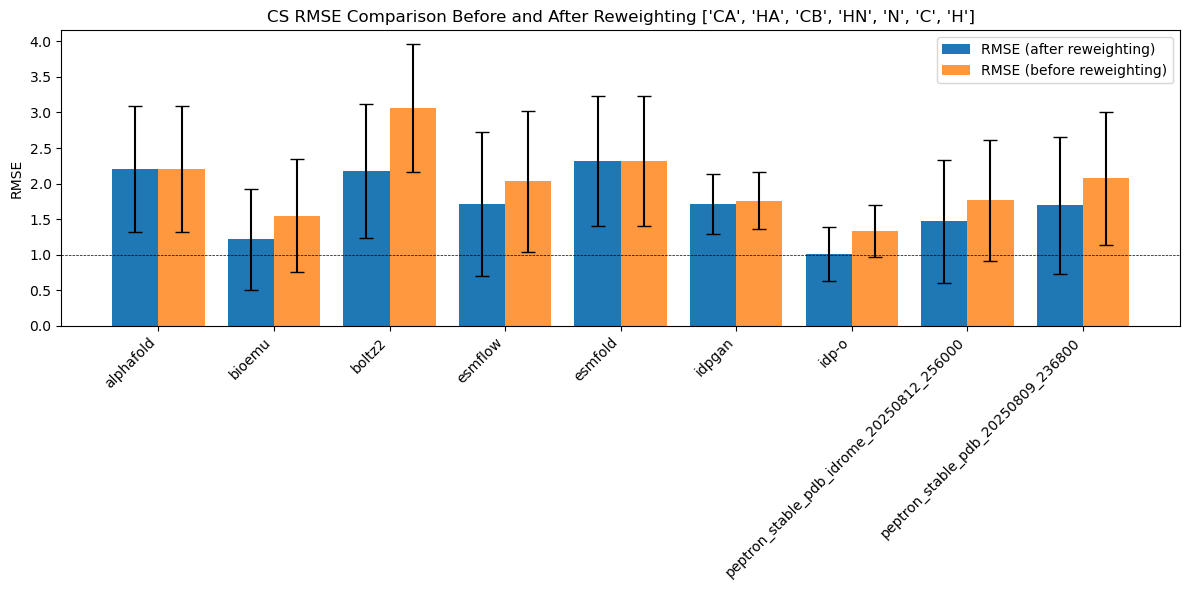

In [5]:
# Create bar positions
x = np.arange(len(df["Model"]))  # the label locations
width = 0.4  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Bars
rects1 = ax.bar(x - width/2, df["RMSE median"], width, yerr=df["RMSE sd"], capsize=5, label="RMSE (after reweighting)")
rects2 = ax.bar(x + width/2, df["RMSE median no rew."], width, yerr=df["RMSE no rew. sd"], capsize=5, label="RMSE (before reweighting)", alpha=0.8)

# Labels and formatting
ax.set_ylabel("RMSE")
ax.set_title(f"CS RMSE Comparison Before and After Reweighting {DEFAULT_SELECTED_ATOM_TYPES}")
ax.set_xticks(x)
ax.set_xticklabels(df["Model"], rotation=45, ha="right")
ax.legend()
ax.axhline(1,color = 'black',linestyle= 'dashed', linewidth=0.5)

plt.tight_layout()
#plt.savefig(output_path+'CS_RMSE_models.png', dpi=300)

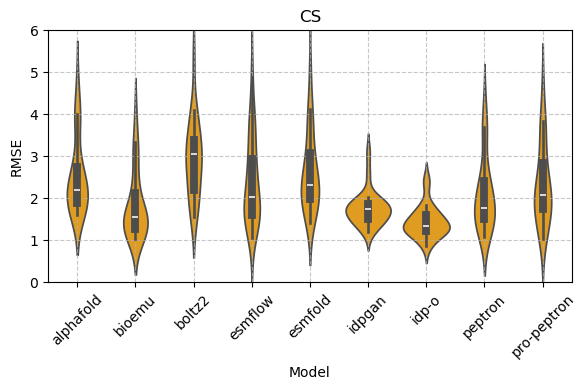

In [6]:
# prior only only

models = ['alphafold','bioemu', 'boltz2', 'esmflow', 'esmfold', 'idpgan', 'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800']


statsdict = {}

for model in models:

    cs_rmse = []
    for ele in allvalues_prior[model]:
        
        cs_rmse.append(ele)
    
    statsdict[model] = {}
    statsdict[model]['CS RMSE'] = cs_rmse

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "peptron"}
)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_20250809_236800": "pro-peptron"}
)

fig, ax = plt.subplots(figsize=(6, 4))


# Violin plot for CS RMSE
sns.violinplot(data=df[df["Metric"]=="CS RMSE"], 
               x="Model", y="Value", inner="box", color="orange")
ax.set_title("CS")
ax.set_ylabel("RMSE")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(0,6)

plt.tight_layout()
#plt.savefig(output_path+f"all_CS_prior.png")


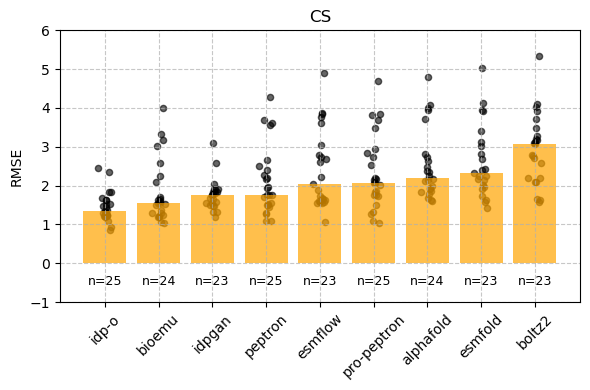

In [7]:


# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "peptron"}
)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_20250809_236800": "pro-peptron"}
)

# Compute medians & counts and sort by median (ascending)
summary = df.groupby("Model")["Value"].agg(["median", "count"]).reset_index()
summary = summary.sort_values("median", ascending=True).reset_index(drop=True)

# Ensure df follows the same model order
df["Model"] = pd.Categorical(df["Model"], categories=summary["Model"], ordered=True)

fig, ax = plt.subplots(figsize=(6, 4))

# Bar plot for medians
bars = ax.bar(summary["Model"], summary["median"], color="orange", alpha=0.7)

# Scatter plot of individual data points with jitter
for i, model in enumerate(summary["Model"]):
    vals = df[df["Model"] == model]["Value"]
    # jitter around the x-position
    np.random.seed(0)
    x_jittered = np.random.normal(loc=i, scale=0.05, size=len(vals))
    ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)

# Annotate counts BELOW the x-ticks
for i, row in summary.iterrows():
    ax.text(i, -0.3, f"n={row['count']}",
            ha="center", va="top", fontsize=9)

ax.set_title("CS")
ax.set_ylabel("RMSE")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(-1, 6)  # extend lower bound so n= fits under bars

plt.tight_layout()
plt.savefig(output_path + "all_CS_prior.png", dpi = 300)


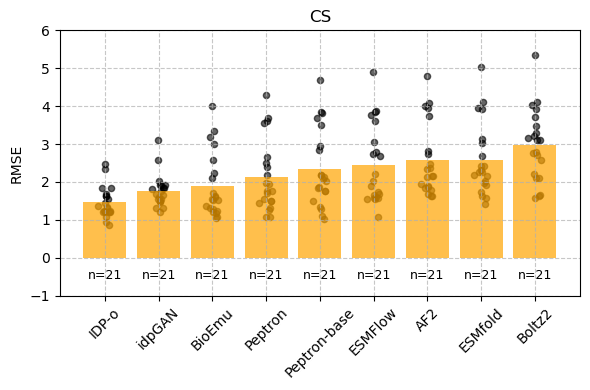

In [37]:
models = ['alphafold','bioemu', 'boltz2', 'esmflow', 'esmfold', 'idpgan', 'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800']

# start with the proteins from the first model
common_proteins = set(next(iter(CSdict.values())).keys())

# take intersection with the proteins from all other models
for model in CSdict.values():
    common_proteins &= set(model.keys())

# convert to a list if needed
common_proteins = list(common_proteins)


statsdict = {}
for model in models:
    cs_rmse = []
    for prot in common_proteins:
        
        cs_rmse.append(CSdict[model][prot]['Prior RMSE'])
    
    statsdict[model] = {}
    statsdict[model]['CS RMSE'] = cs_rmse

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "Peptron",
     "peptron_stable_pdb_20250809_236800": "Peptron-base",
     "idp-o": "IDP-o",
     "boltz2": "Boltz2",
     "alphafold": "AF2",
     "esmfold": "ESMfold",
     "idpgan": "idpGAN",
     "bioemu": "BioEmu",
     "esmflow": "ESMFlow"}
)

# Compute mean & counts and sort by mean (ascending)
summary = df.groupby("Model")["Value"].agg(["mean", "count"]).reset_index()
summary = summary.sort_values("mean", ascending=True).reset_index(drop=True)

# Ensure df follows the same model order
df["Model"] = pd.Categorical(df["Model"], categories=summary["Model"], ordered=True)

fig, ax = plt.subplots(figsize=(6, 4))

# Bar plot for mean
bars = ax.bar(summary["Model"], summary["mean"], color="orange", alpha=0.7)

# Scatter plot of individual data points with jitter
for i, model in enumerate(summary["Model"]):
    vals = df[df["Model"] == model]["Value"]
    # jitter around the x-position
    np.random.seed(0)
    x_jittered = np.random.normal(loc=i, scale=0.05, size=len(vals))
    ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)

# Annotate counts BELOW the x-ticks
for i, row in summary.iterrows():
    ax.text(i, -0.3, f"n={row['count']}",
            ha="center", va="top", fontsize=9)

ax.set_title("CS")
ax.set_ylabel("RMSE")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(-1, 6)  # extend lower bound so n= fits under bars

plt.tight_layout()
plt.savefig(output_path + "all_ranked_CS_prior_common_proteins_mean.png", dpi = 300)


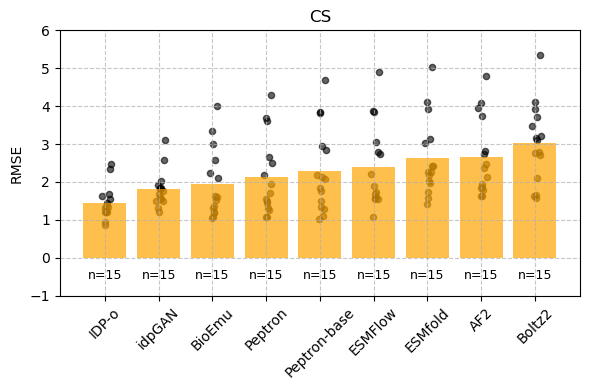

In [38]:
models = ['alphafold','bioemu', 'boltz2', 'esmflow', 'esmfold', 'idpgan', 'idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'peptron_stable_pdb_20250809_236800']

# start with the proteins from the first model
common_proteins = set(next(iter(CSdict.values())).keys())

# take intersection with the proteins from all other models
for model in CSdict.values():
    common_proteins &= set(model.keys())

# convert to a list if needed
common_proteins = list(common_proteins)


statsdict = {}
for model in models:
    cs_rmse = []
    for prot in common_proteins:

        # check if SAXSrew around
        if not os.path.exists(f"../protonated_predictions/{model}/{prot}/SAXSrew.npy"):
            continue
        
        cs_rmse.append(CSdict[model][prot]['Prior RMSE'])
    
    statsdict[model] = {}
    statsdict[model]['CS RMSE'] = cs_rmse

# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "Peptron",
     "peptron_stable_pdb_20250809_236800": "Peptron-base",
     "idp-o": "IDP-o",
     "boltz2": "Boltz2",
     "alphafold": "AF2",
     "esmfold": "ESMfold",
     "idpgan": "idpGAN",
     "bioemu": "BioEmu",
     "esmflow": "ESMFlow"}
)

# Compute mean & counts and sort by mean (ascending)
summary = df.groupby("Model")["Value"].agg(["mean", "count"]).reset_index()
summary = summary.sort_values("mean", ascending=True).reset_index(drop=True)

# Ensure df follows the same model order
df["Model"] = pd.Categorical(df["Model"], categories=summary["Model"], ordered=True)

fig, ax = plt.subplots(figsize=(6, 4))

# Bar plot for mean
bars = ax.bar(summary["Model"], summary["mean"], color="orange", alpha=0.7)

# Scatter plot of individual data points with jitter
for i, model in enumerate(summary["Model"]):
    vals = df[df["Model"] == model]["Value"]
    # jitter around the x-position
    np.random.seed(0)
    x_jittered = np.random.normal(loc=i, scale=0.05, size=len(vals))
    ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)

# Annotate counts BELOW the x-ticks
for i, row in summary.iterrows():
    ax.text(i, -0.3, f"n={row['count']}",
            ha="center", va="top", fontsize=9)

ax.set_title("CS")
ax.set_ylabel("RMSE")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(-1, 6)  # extend lower bound so n= fits under bars

plt.tight_layout()
plt.savefig(output_path + "all_ranked_CS_prior_common_proteins_mean_SAXSintersection.png", dpi = 300)


In [ ]:


# Convert statsdict into a dataframe
data = []
for model, vals in statsdict.items():
    for cs in vals['CS RMSE']:
        data.append({"Model": model, "Metric": "CS RMSE", "Value": cs})

df = pd.DataFrame(data)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_idrome_20250812_256000": "peptron"}
)
df["Model"] = df["Model"].replace(
    {"peptron_stable_pdb_20250809_236800": "pro-peptron"}
)

# Compute medians & counts and sort by median (ascending)
summary = df.groupby("Model")["Value"].agg(["median", "count"]).reset_index()
summary = summary.sort_values("median", ascending=True).reset_index(drop=True)

# Ensure df follows the same model order
df["Model"] = pd.Categorical(df["Model"], categories=summary["Model"], ordered=True)

fig, ax = plt.subplots(figsize=(6, 4))

# Bar plot for medians
bars = ax.bar(summary["Model"], summary["median"], color="orange", alpha=0.7)

# Scatter plot of individual data points with jitter
for i, model in enumerate(summary["Model"]):
    vals = df[df["Model"] == model]["Value"]
    # jitter around the x-position
    np.random.seed(0)
    x_jittered = np.random.normal(loc=i, scale=0.05, size=len(vals))
    ax.scatter(x_jittered, vals, color="black", alpha=0.6, s=20)

# Annotate counts BELOW the x-ticks
for i, row in summary.iterrows():
    ax.text(i, -0.3, f"n={row['count']}",
            ha="center", va="top", fontsize=9)

ax.set_title("CS")
ax.set_ylabel("RMSE")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
ax.set_ylim(-1, 6)  # extend lower bound so n= fits under bars

plt.tight_layout()
#plt.savefig(output_path + "all_CS_prior.png", dpi = 300)


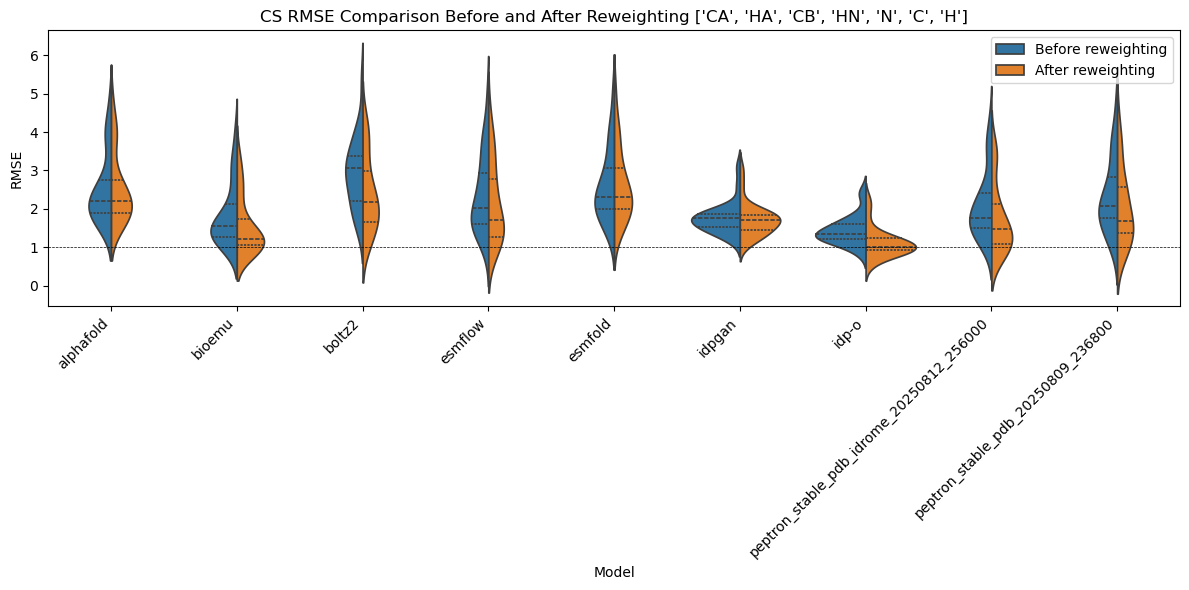

In [8]:
# violin plot

df_list = []

# Before reweighting
for model, vals in allvalues_prior.items():
    df_list.append(pd.DataFrame({
        "Model": model,
        "Condition": "Before reweighting",
        "RMSE": vals
    }))

# After reweighting
for model, vals in allvalues.items():
    df_list.append(pd.DataFrame({
        "Model": model,
        "Condition": "After reweighting",
        "RMSE": vals
    }))

# Combine into long DataFrame
df_long = pd.concat(df_list, ignore_index=True)

# Plot violin plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(
    data=df_long,
    x="Model",
    y="RMSE",
    hue="Condition",
    split=True,        # both distributions in one violin per model
    inner="quartile",  # show median and quartiles
    ax=ax
)

# Formatting
ax.set_ylabel("RMSE")
ax.set_title(f"CS RMSE Comparison Before and After Reweighting {DEFAULT_SELECTED_ATOM_TYPES}")
ax.axhline(1, color="black", linestyle="dashed", linewidth=0.5)
ax.legend(title="")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
#plt.savefig(output_path+"CS_RMSE_violin.png", dpi=300)

In [ ]:
# calculate random coil chemical shifts for all sequences for the secondary shift analysis below

outpath = './potenci_data/'
exp_path = '../EXP_DATA/'

for prot in CSproteins:

    # load experimental conditions table
    df = pd.read_csv(exp_path+f'{prot}/info.csv')
    df = df[df['Experiment']=='CS']
    temp = list(df['Temp(K)'])[0]
    pH = list(df['pH'])[0]
    ionic = list(df['Ionic(M)'])[0]

    # load sequence
    with open(f'../EXP_DATA/{prot}/seq.fasta','r') as f:
        seq= str(f.readlines()[1].strip())

    # run potenci prediction
    shiftdct = potenci.getpredshifts(seq=seq, temperature=temp, pH=pH, ion=ionic, usephcor=pH < 6.99 or pH > 7.01, pkacsvfile=False)
    potenci.writeOutput(outpath+str(f'{prot}_RCshifts.dat'), shiftdct)
    
print('Done')

Done


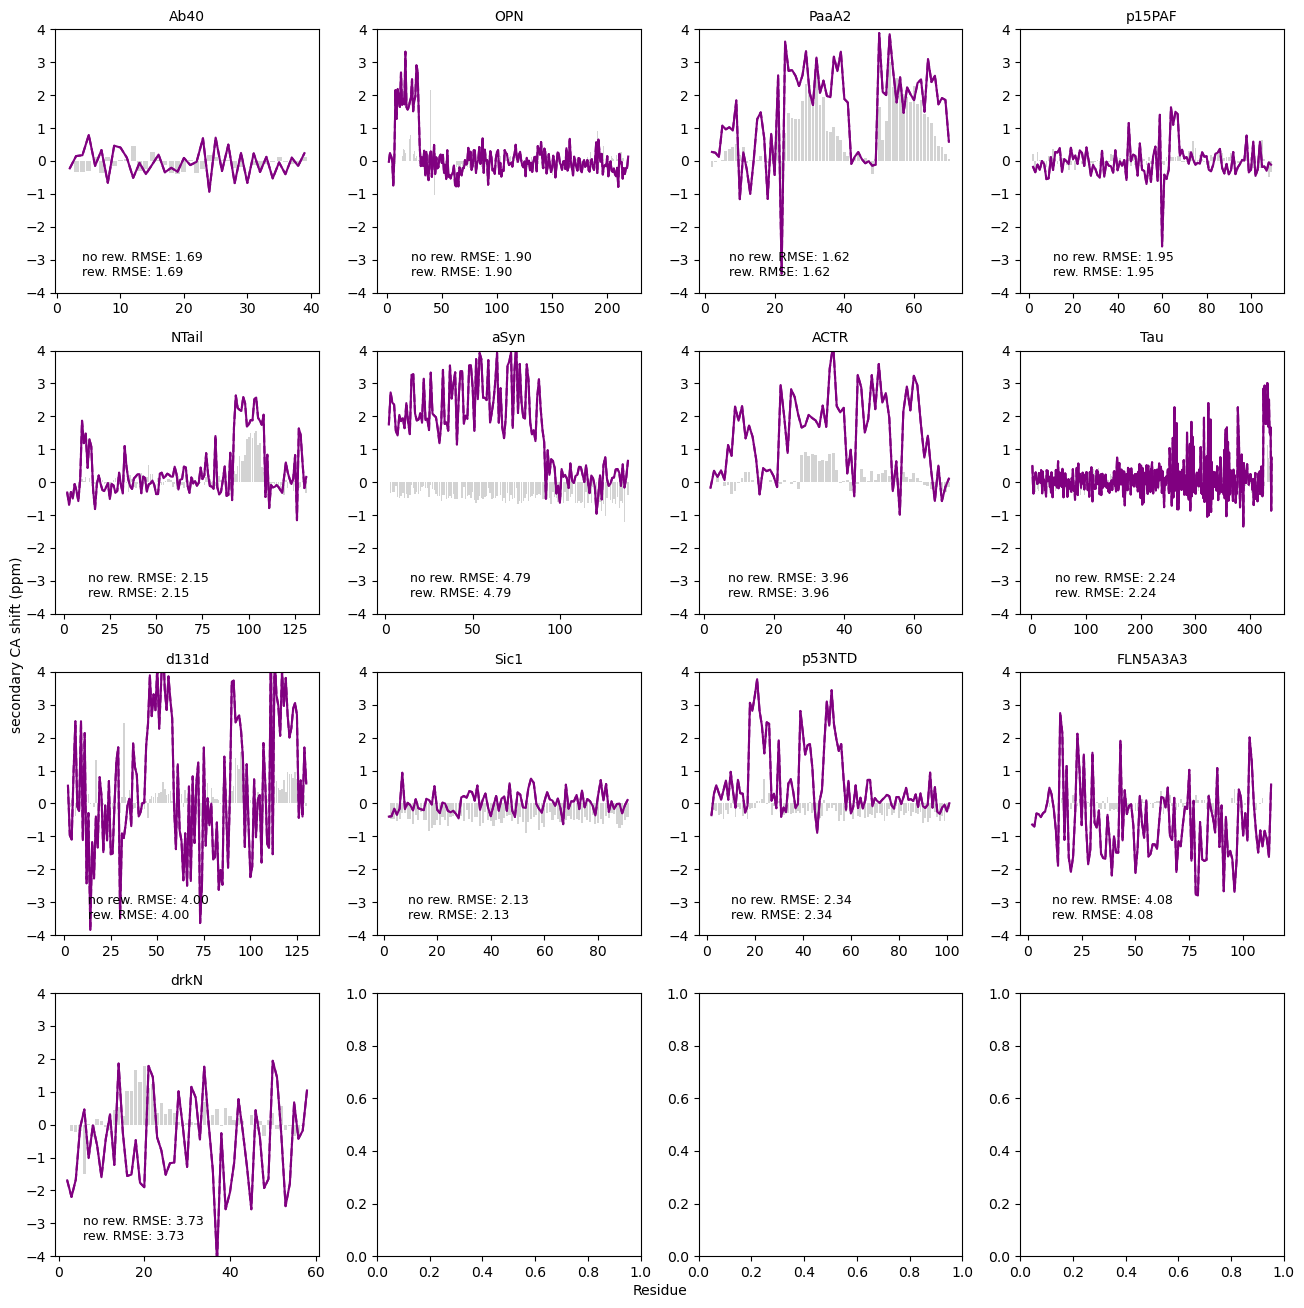

In [ ]:
# final comparison of generated ensembles and experimental data: prior and optimal posterior (cross-validated with RDCs)

# plot CA secondary shifts (using potenci for random coil) - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'alphafold'

nucleus = 'CA'
ESS_threshold=100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
# RDC cross validation data
### MAKE SURE TO REPLACE THESE EXAMPLE PATHS WITH YOUR PATHS AND TO HAVE THE RDC_CSREW CROSS CORRELATION FILE SAVED (analyse_IntegrativeDB_RDC.ipynb)
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

PROTEINS = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*1,len(PROTEINS)*1))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # load experimental shifts
    expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat', bmrb_stats_file, sigma_cutoff=3.0)

    # load RC shifts
    potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx
    # extract weights
    weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
    weights_nan = csrew['weights']

    # load calculated chemical shifts
    calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

    # calculate experimental secondary shifts
    potenci_residues = []
    potenci_shifts = []
    for key in list(potenci.keys()):
        if key[1]==nucleus:
            potenci_residues.append(key[0])
            potenci_shifts.append(potenci[key])

    exp_residues = []
    exp_shifts = []
    for key in list(expshifts.keys()):
        if key[1]==nucleus:
            exp_residues.append(key[0])
            exp_shifts.append(expshifts[key])

    potenci_residues = np.array(potenci_residues)
    potenci_shifts = np.array(potenci_shifts)
    exp_residues = np.array(exp_residues)
    exp_shifts = np.array(exp_shifts)

    common_residues = np.intersect1d(potenci_residues, exp_residues)
    indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
    indices_e = np.where(np.isin(exp_residues, common_residues))[0]
    SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

    # calculated secondary shifts from models (before/after reweighting)
    calc_vals = []
    calc_residues = []
    for res in potenci_residues:
        try:
            calc_vals.append(list(calcshifts.loc[res, nucleus]))
            calc_residues.append(res)
        except KeyError:
            continue

    calc_residues = np.array(calc_residues)
    calc_vals = np.array(calc_vals).T

    # Average across models
    prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)  # remove unphysical structures
    posterior = np.average(calc_vals, weights=weights, axis=0)

    # Align Potenci shifts with calc_residues
    indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
    potenci_for_calc = potenci_shifts[indices_p2]

    # Now compute secondary shifts
    SSprior = prior - potenci_for_calc
    SSposterior = posterior - potenci_for_calc


    ax.bar(exp_residues[indices_e], SSexp, color = 'lightgrey')
    ax.plot(calc_residues, SSprior, color = 'purple', label='no rew.', linestyle='dashed')
    ax.plot(calc_residues, SSposterior, color = 'purple', label='rew.')
    ax.set_ylim(-4,4)

    text_string = str("no rew. RMSE: {:.2f}\n".format(csrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(csrew['all_post_rmse'][opt_post_idx]))
    ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SSshifts_{nucleus}_{model}_exp_vs_calc.png', dpi=200)



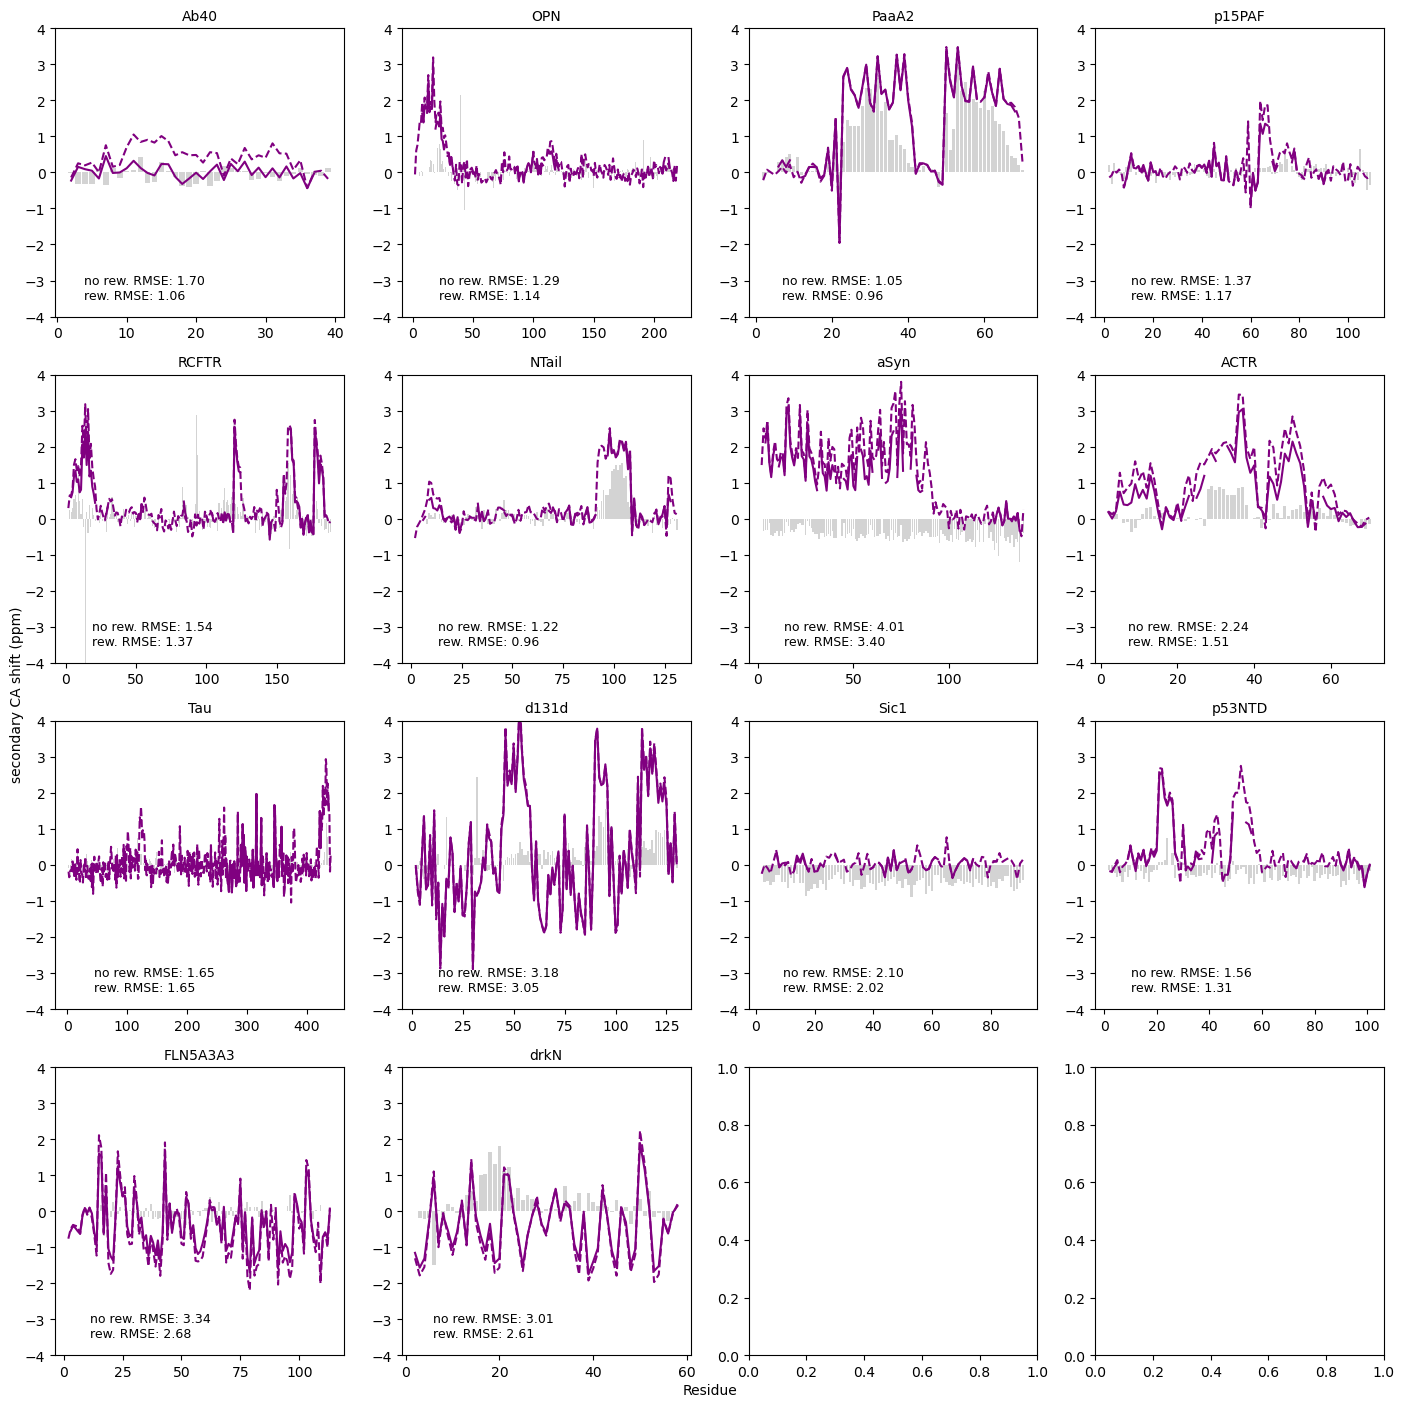

In [10]:
# final comparison of generated ensembles and experimental data: prior and optimal posterior (cross-validated with RDCs)

# plot CA secondary shifts (using potenci for random coil) - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'bioemu'

nucleus = 'CA'
ESS_threshold=100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

PROTEINS = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*1,len(PROTEINS)*1))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # load experimental shifts
    expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat', bmrb_stats_file, sigma_cutoff=3.0)

    # load RC shifts
    potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx
    # extract weights
    weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
    weights_nan = csrew['weights']

    # load calculated chemical shifts
    calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

    # calculate experimental secondary shifts
    potenci_residues = []
    potenci_shifts = []
    for key in list(potenci.keys()):
        if key[1]==nucleus:
            potenci_residues.append(key[0])
            potenci_shifts.append(potenci[key])

    exp_residues = []
    exp_shifts = []
    for key in list(expshifts.keys()):
        if key[1]==nucleus:
            exp_residues.append(key[0])
            exp_shifts.append(expshifts[key])

    potenci_residues = np.array(potenci_residues)
    potenci_shifts = np.array(potenci_shifts)
    exp_residues = np.array(exp_residues)
    exp_shifts = np.array(exp_shifts)

    common_residues = np.intersect1d(potenci_residues, exp_residues)
    indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
    indices_e = np.where(np.isin(exp_residues, common_residues))[0]
    SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

    # calculated secondary shifts from models (before/after reweighting)
    calc_vals = []
    calc_residues = []
    for res in potenci_residues:
        try:
            calc_vals.append(list(calcshifts.loc[res, nucleus]))
            calc_residues.append(res)
        except KeyError:
            continue

    calc_residues = np.array(calc_residues)
    calc_vals = np.array(calc_vals).T

    # Average across models
    prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)  # remove unphysical structures
    posterior = np.average(calc_vals, weights=weights, axis=0)

    # Align Potenci shifts with calc_residues
    indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
    potenci_for_calc = potenci_shifts[indices_p2]

    # Now compute secondary shifts
    SSprior = prior - potenci_for_calc
    SSposterior = posterior - potenci_for_calc


    ax.bar(exp_residues[indices_e], SSexp, color = 'lightgrey')
    ax.plot(calc_residues, SSprior, color = 'purple', label='no rew.', linestyle='dashed')
    ax.plot(calc_residues, SSposterior, color = 'purple', label='rew.')
    ax.set_ylim(-4,4)

    text_string = str("no rew. RMSE: {:.2f}\n".format(csrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(csrew['all_post_rmse'][opt_post_idx]))
    ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SSshifts_{nucleus}_{model}_exp_vs_calc.png', dpi=200)



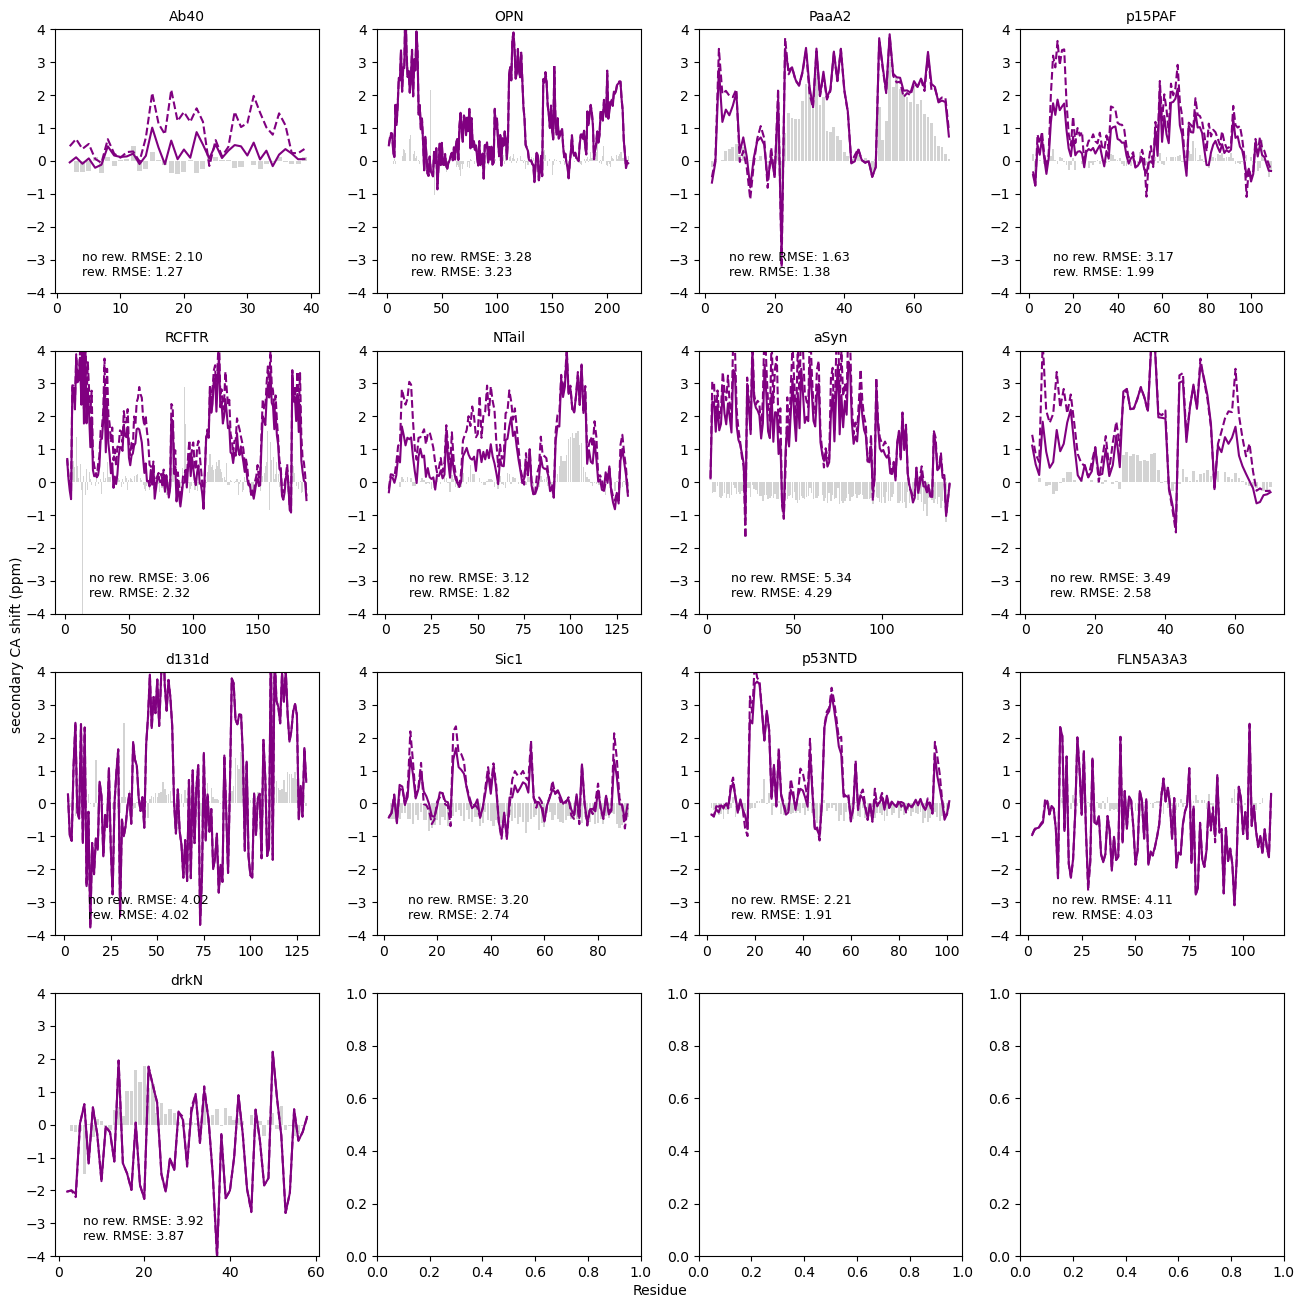

In [11]:
# final comparison of generated ensembles and experimental data: prior and optimal posterior (cross-validated with RDCs)

# plot CA secondary shifts (using potenci for random coil) - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'boltz2'

nucleus = 'CA'
ESS_threshold=100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

PROTEINS = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*1,len(PROTEINS)*1))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # load experimental shifts
    expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat', bmrb_stats_file, sigma_cutoff=3.0)

    # load RC shifts
    potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx
    # extract weights
    weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
    weights_nan = csrew['weights']

    # load calculated chemical shifts
    calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

    # calculate experimental secondary shifts
    potenci_residues = []
    potenci_shifts = []
    for key in list(potenci.keys()):
        if key[1]==nucleus:
            potenci_residues.append(key[0])
            potenci_shifts.append(potenci[key])

    exp_residues = []
    exp_shifts = []
    for key in list(expshifts.keys()):
        if key[1]==nucleus:
            exp_residues.append(key[0])
            exp_shifts.append(expshifts[key])

    potenci_residues = np.array(potenci_residues)
    potenci_shifts = np.array(potenci_shifts)
    exp_residues = np.array(exp_residues)
    exp_shifts = np.array(exp_shifts)

    common_residues = np.intersect1d(potenci_residues, exp_residues)
    indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
    indices_e = np.where(np.isin(exp_residues, common_residues))[0]
    SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

    # calculated secondary shifts from models (before/after reweighting)
    calc_vals = []
    calc_residues = []
    for res in potenci_residues:
        try:
            calc_vals.append(list(calcshifts.loc[res, nucleus]))
            calc_residues.append(res)
        except KeyError:
            continue

    calc_residues = np.array(calc_residues)
    calc_vals = np.array(calc_vals).T

    # Average across models
    prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)  # remove unphysical structures
    posterior = np.average(calc_vals, weights=weights, axis=0)

    # Align Potenci shifts with calc_residues
    indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
    potenci_for_calc = potenci_shifts[indices_p2]

    # Now compute secondary shifts
    SSprior = prior - potenci_for_calc
    SSposterior = posterior - potenci_for_calc


    ax.bar(exp_residues[indices_e], SSexp, color = 'lightgrey')
    ax.plot(calc_residues, SSprior, color = 'purple', label='no rew.', linestyle='dashed')
    ax.plot(calc_residues, SSposterior, color = 'purple', label='rew.')
    ax.set_ylim(-4,4)

    text_string = str("no rew. RMSE: {:.2f}\n".format(csrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(csrew['all_post_rmse'][opt_post_idx]))
    ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SSshifts_{nucleus}_{model}_exp_vs_calc.png', dpi=200)



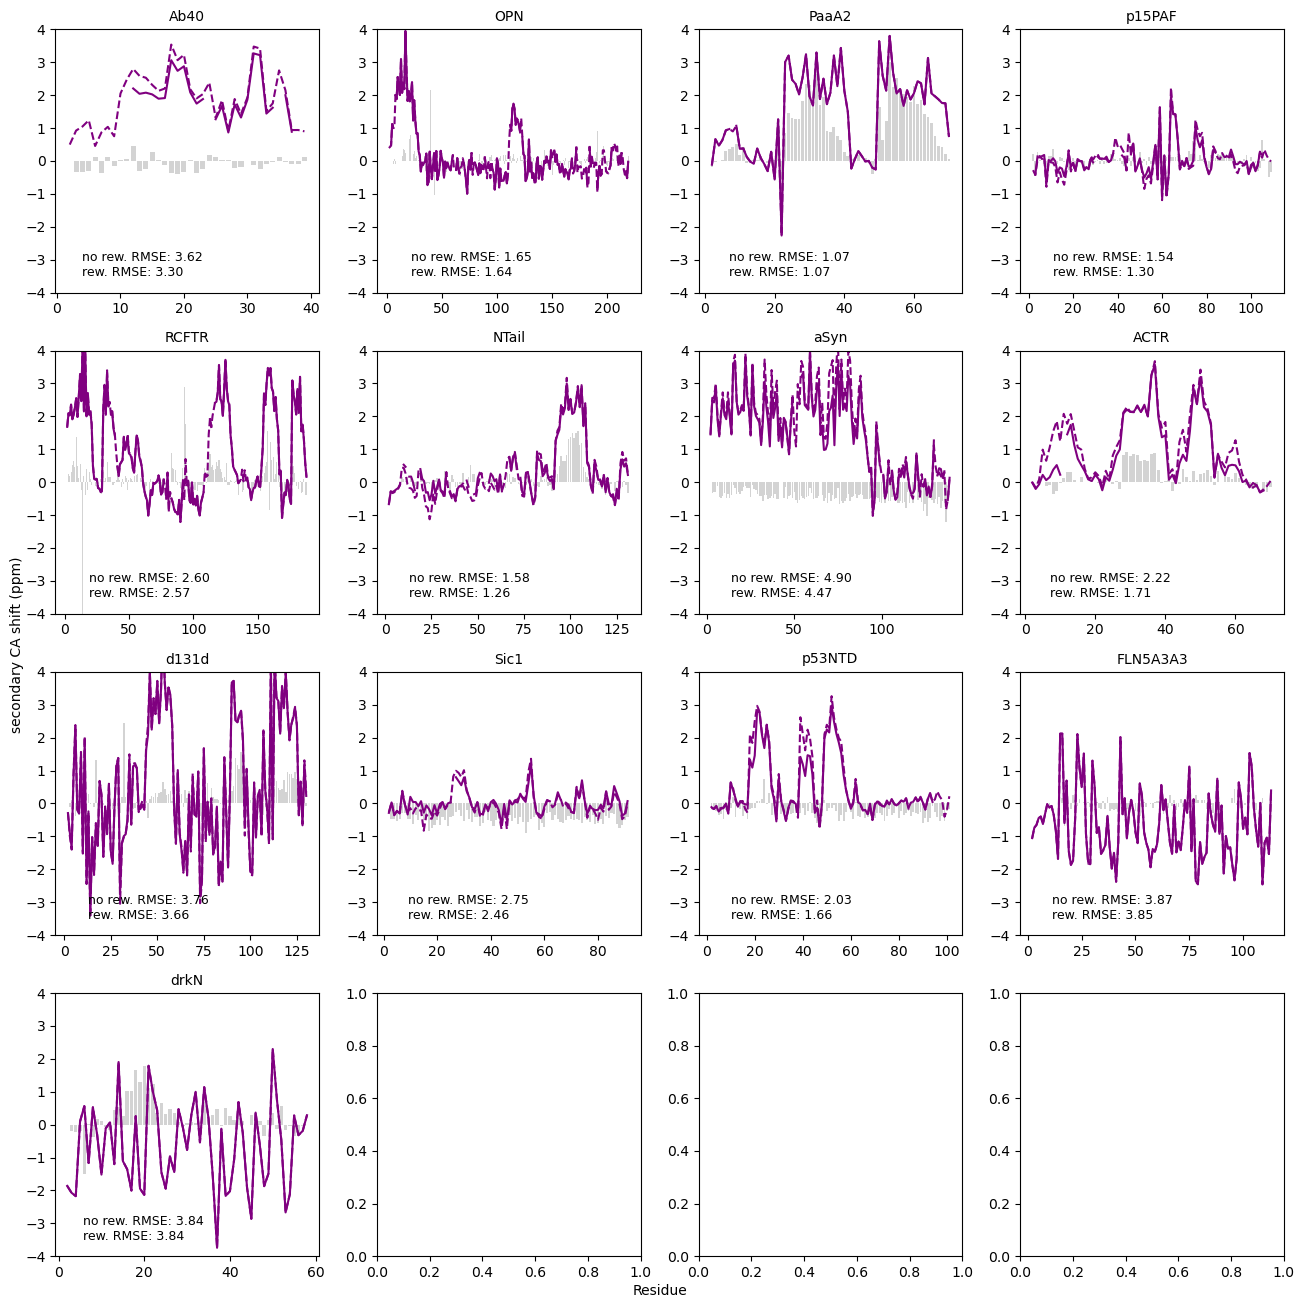

In [12]:
# final comparison of generated ensembles and experimental data: prior and optimal posterior (cross-validated with RDCs)

# plot CA secondary shifts (using potenci for random coil) - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'esmflow'

nucleus = 'CA'
ESS_threshold=100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

PROTEINS = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*1,len(PROTEINS)*1))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # load experimental shifts
    expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat', bmrb_stats_file, sigma_cutoff=3.0)

    # load RC shifts
    potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx
    # extract weights
    weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
    weights_nan = csrew['weights']

    # load calculated chemical shifts
    calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

    # calculate experimental secondary shifts
    potenci_residues = []
    potenci_shifts = []
    for key in list(potenci.keys()):
        if key[1]==nucleus:
            potenci_residues.append(key[0])
            potenci_shifts.append(potenci[key])

    exp_residues = []
    exp_shifts = []
    for key in list(expshifts.keys()):
        if key[1]==nucleus:
            exp_residues.append(key[0])
            exp_shifts.append(expshifts[key])

    potenci_residues = np.array(potenci_residues)
    potenci_shifts = np.array(potenci_shifts)
    exp_residues = np.array(exp_residues)
    exp_shifts = np.array(exp_shifts)

    common_residues = np.intersect1d(potenci_residues, exp_residues)
    indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
    indices_e = np.where(np.isin(exp_residues, common_residues))[0]
    SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

    # calculated secondary shifts from models (before/after reweighting)
    calc_vals = []
    calc_residues = []
    for res in potenci_residues:
        try:
            calc_vals.append(list(calcshifts.loc[res, nucleus]))
            calc_residues.append(res)
        except KeyError:
            continue

    calc_residues = np.array(calc_residues)
    calc_vals = np.array(calc_vals).T

    # Average across models
    prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)  # remove unphysical structures
    posterior = np.average(calc_vals, weights=weights, axis=0)

    # Align Potenci shifts with calc_residues
    indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
    potenci_for_calc = potenci_shifts[indices_p2]

    # Now compute secondary shifts
    SSprior = prior - potenci_for_calc
    SSposterior = posterior - potenci_for_calc


    ax.bar(exp_residues[indices_e], SSexp, color = 'lightgrey')
    ax.plot(calc_residues, SSprior, color = 'purple', label='no rew.', linestyle='dashed')
    ax.plot(calc_residues, SSposterior, color = 'purple', label='rew.')
    ax.set_ylim(-4,4)

    text_string = str("no rew. RMSE: {:.2f}\n".format(csrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(csrew['all_post_rmse'][opt_post_idx]))
    ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SSshifts_{nucleus}_{model}_exp_vs_calc.png', dpi=200)



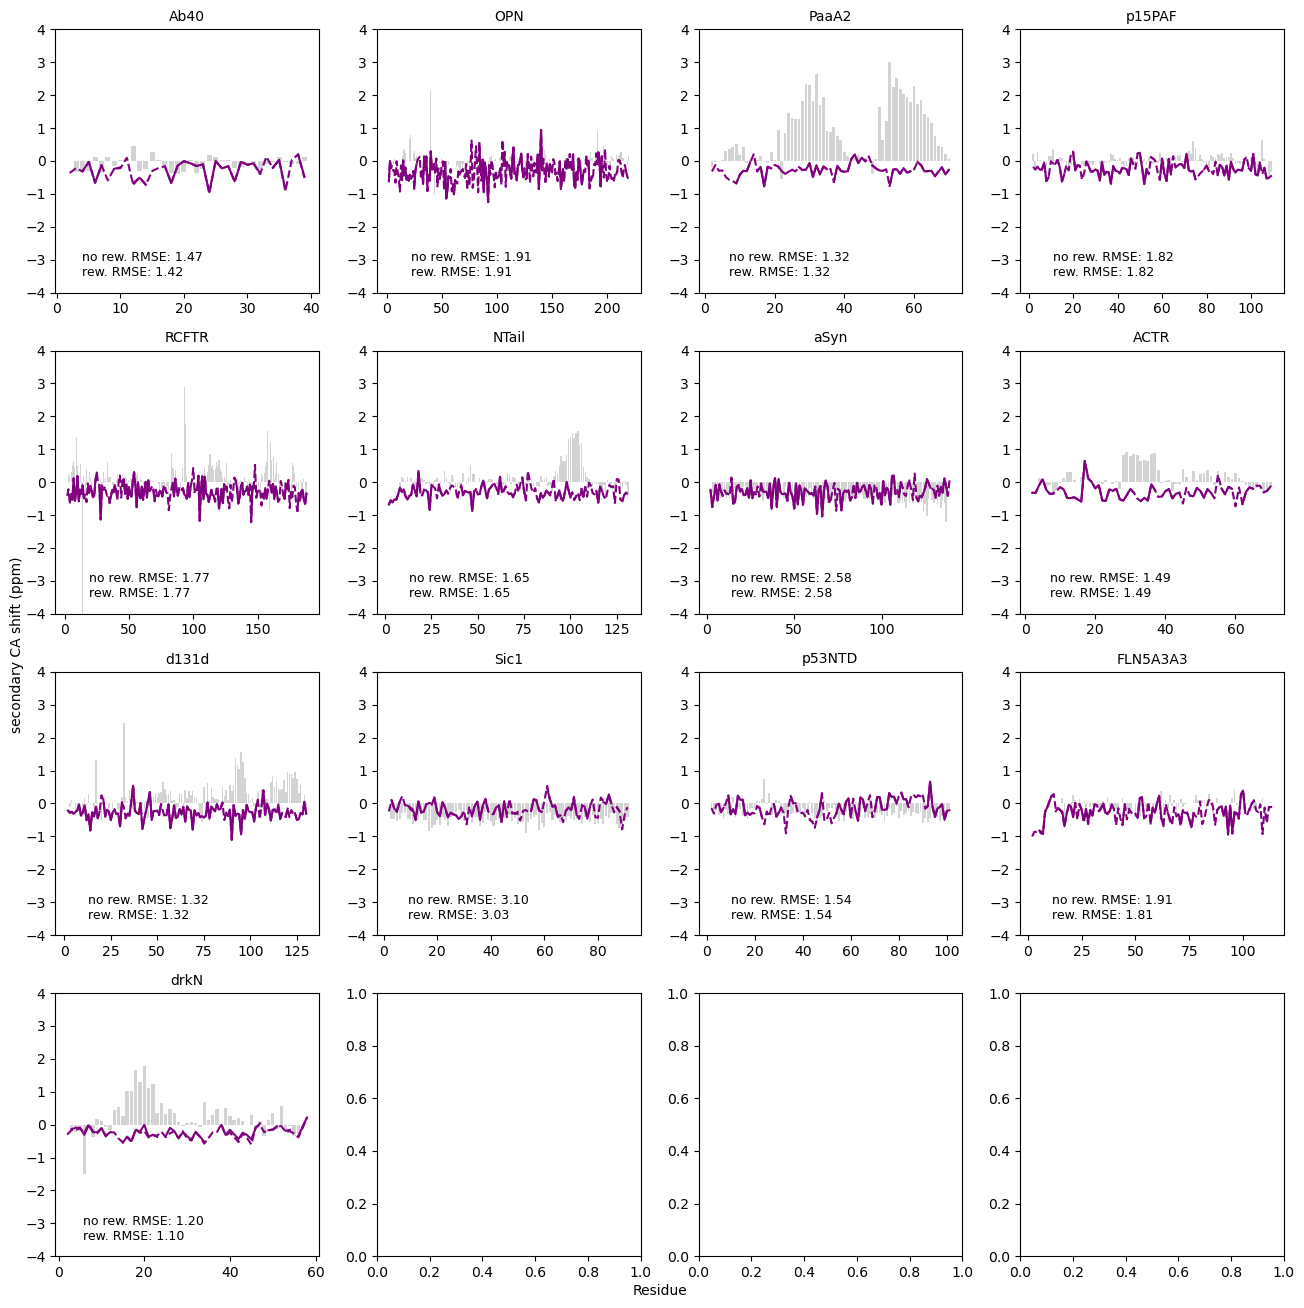

In [13]:
# final comparison of generated ensembles and experimental data: prior and optimal posterior (cross-validated with RDCs)

# plot CA secondary shifts (using potenci for random coil) - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'idpgan'

nucleus = 'CA'
ESS_threshold=100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

PROTEINS = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*1,len(PROTEINS)*1))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # load experimental shifts
    expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat', bmrb_stats_file, sigma_cutoff=3.0)

    # load RC shifts
    potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx
    # extract weights
    weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
    weights_nan = csrew['weights']

    # load calculated chemical shifts
    calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

    # calculate experimental secondary shifts
    potenci_residues = []
    potenci_shifts = []
    for key in list(potenci.keys()):
        if key[1]==nucleus:
            potenci_residues.append(key[0])
            potenci_shifts.append(potenci[key])

    exp_residues = []
    exp_shifts = []
    for key in list(expshifts.keys()):
        if key[1]==nucleus:
            exp_residues.append(key[0])
            exp_shifts.append(expshifts[key])

    potenci_residues = np.array(potenci_residues)
    potenci_shifts = np.array(potenci_shifts)
    exp_residues = np.array(exp_residues)
    exp_shifts = np.array(exp_shifts)

    common_residues = np.intersect1d(potenci_residues, exp_residues)
    indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
    indices_e = np.where(np.isin(exp_residues, common_residues))[0]
    SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

    # calculated secondary shifts from models (before/after reweighting)
    calc_vals = []
    calc_residues = []
    for res in potenci_residues:
        try:
            calc_vals.append(list(calcshifts.loc[res, nucleus]))
            calc_residues.append(res)
        except KeyError:
            continue

    calc_residues = np.array(calc_residues)
    calc_vals = np.array(calc_vals).T

    # Average across models
    prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)  # remove unphysical structures
    posterior = np.average(calc_vals, weights=weights, axis=0)

    # Align Potenci shifts with calc_residues
    indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
    potenci_for_calc = potenci_shifts[indices_p2]

    # Now compute secondary shifts
    SSprior = prior - potenci_for_calc
    SSposterior = posterior - potenci_for_calc


    ax.bar(exp_residues[indices_e], SSexp, color = 'lightgrey')
    ax.plot(calc_residues, SSprior, color = 'purple', label='no rew.', linestyle='dashed')
    ax.plot(calc_residues, SSposterior, color = 'purple', label='rew.')
    ax.set_ylim(-4,4)

    text_string = str("no rew. RMSE: {:.2f}\n".format(csrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(csrew['all_post_rmse'][opt_post_idx]))
    ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SSshifts_{nucleus}_{model}_exp_vs_calc.png', dpi=200)



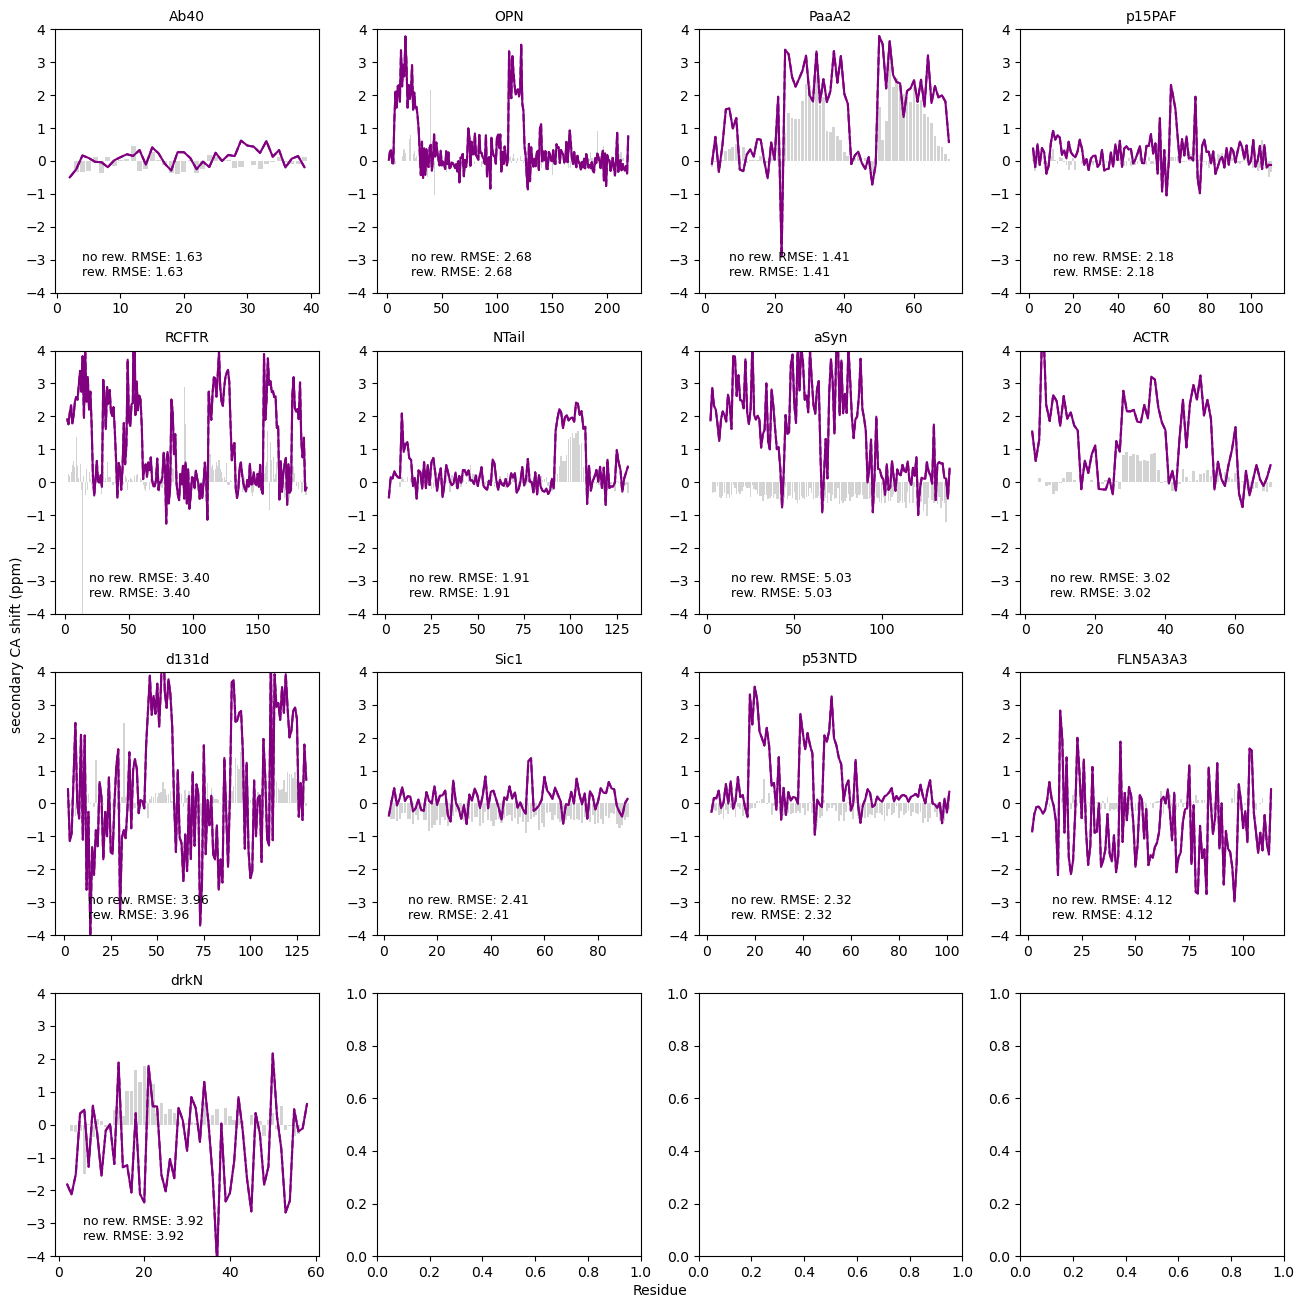

In [14]:
# final comparison of generated ensembles and experimental data: prior and optimal posterior (cross-validated with RDCs)

# plot CA secondary shifts (using potenci for random coil) - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'esmfold'

nucleus = 'CA'
ESS_threshold=100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

PROTEINS = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*1,len(PROTEINS)*1))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # load experimental shifts
    expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat', bmrb_stats_file, sigma_cutoff=3.0)

    # load RC shifts
    potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx
    # extract weights
    weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
    weights_nan = csrew['weights']

    # load calculated chemical shifts
    calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

    # calculate experimental secondary shifts
    potenci_residues = []
    potenci_shifts = []
    for key in list(potenci.keys()):
        if key[1]==nucleus:
            potenci_residues.append(key[0])
            potenci_shifts.append(potenci[key])

    exp_residues = []
    exp_shifts = []
    for key in list(expshifts.keys()):
        if key[1]==nucleus:
            exp_residues.append(key[0])
            exp_shifts.append(expshifts[key])

    potenci_residues = np.array(potenci_residues)
    potenci_shifts = np.array(potenci_shifts)
    exp_residues = np.array(exp_residues)
    exp_shifts = np.array(exp_shifts)

    common_residues = np.intersect1d(potenci_residues, exp_residues)
    indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
    indices_e = np.where(np.isin(exp_residues, common_residues))[0]
    SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

    # calculated secondary shifts from models (before/after reweighting)
    calc_vals = []
    calc_residues = []
    for res in potenci_residues:
        try:
            calc_vals.append(list(calcshifts.loc[res, nucleus]))
            calc_residues.append(res)
        except KeyError:
            continue

    calc_residues = np.array(calc_residues)
    calc_vals = np.array(calc_vals).T

    # Average across models
    prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)  # remove unphysical structures
    posterior = np.average(calc_vals, weights=weights, axis=0)

    # Align Potenci shifts with calc_residues
    indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
    potenci_for_calc = potenci_shifts[indices_p2]

    # Now compute secondary shifts
    SSprior = prior - potenci_for_calc
    SSposterior = posterior - potenci_for_calc


    ax.bar(exp_residues[indices_e], SSexp, color = 'lightgrey')
    ax.plot(calc_residues, SSprior, color = 'purple', label='no rew.', linestyle='dashed')
    ax.plot(calc_residues, SSposterior, color = 'purple', label='rew.')
    ax.set_ylim(-4,4)

    text_string = str("no rew. RMSE: {:.2f}\n".format(csrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(csrew['all_post_rmse'][opt_post_idx]))
    ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SSshifts_{nucleus}_{model}_exp_vs_calc.png', dpi=200)



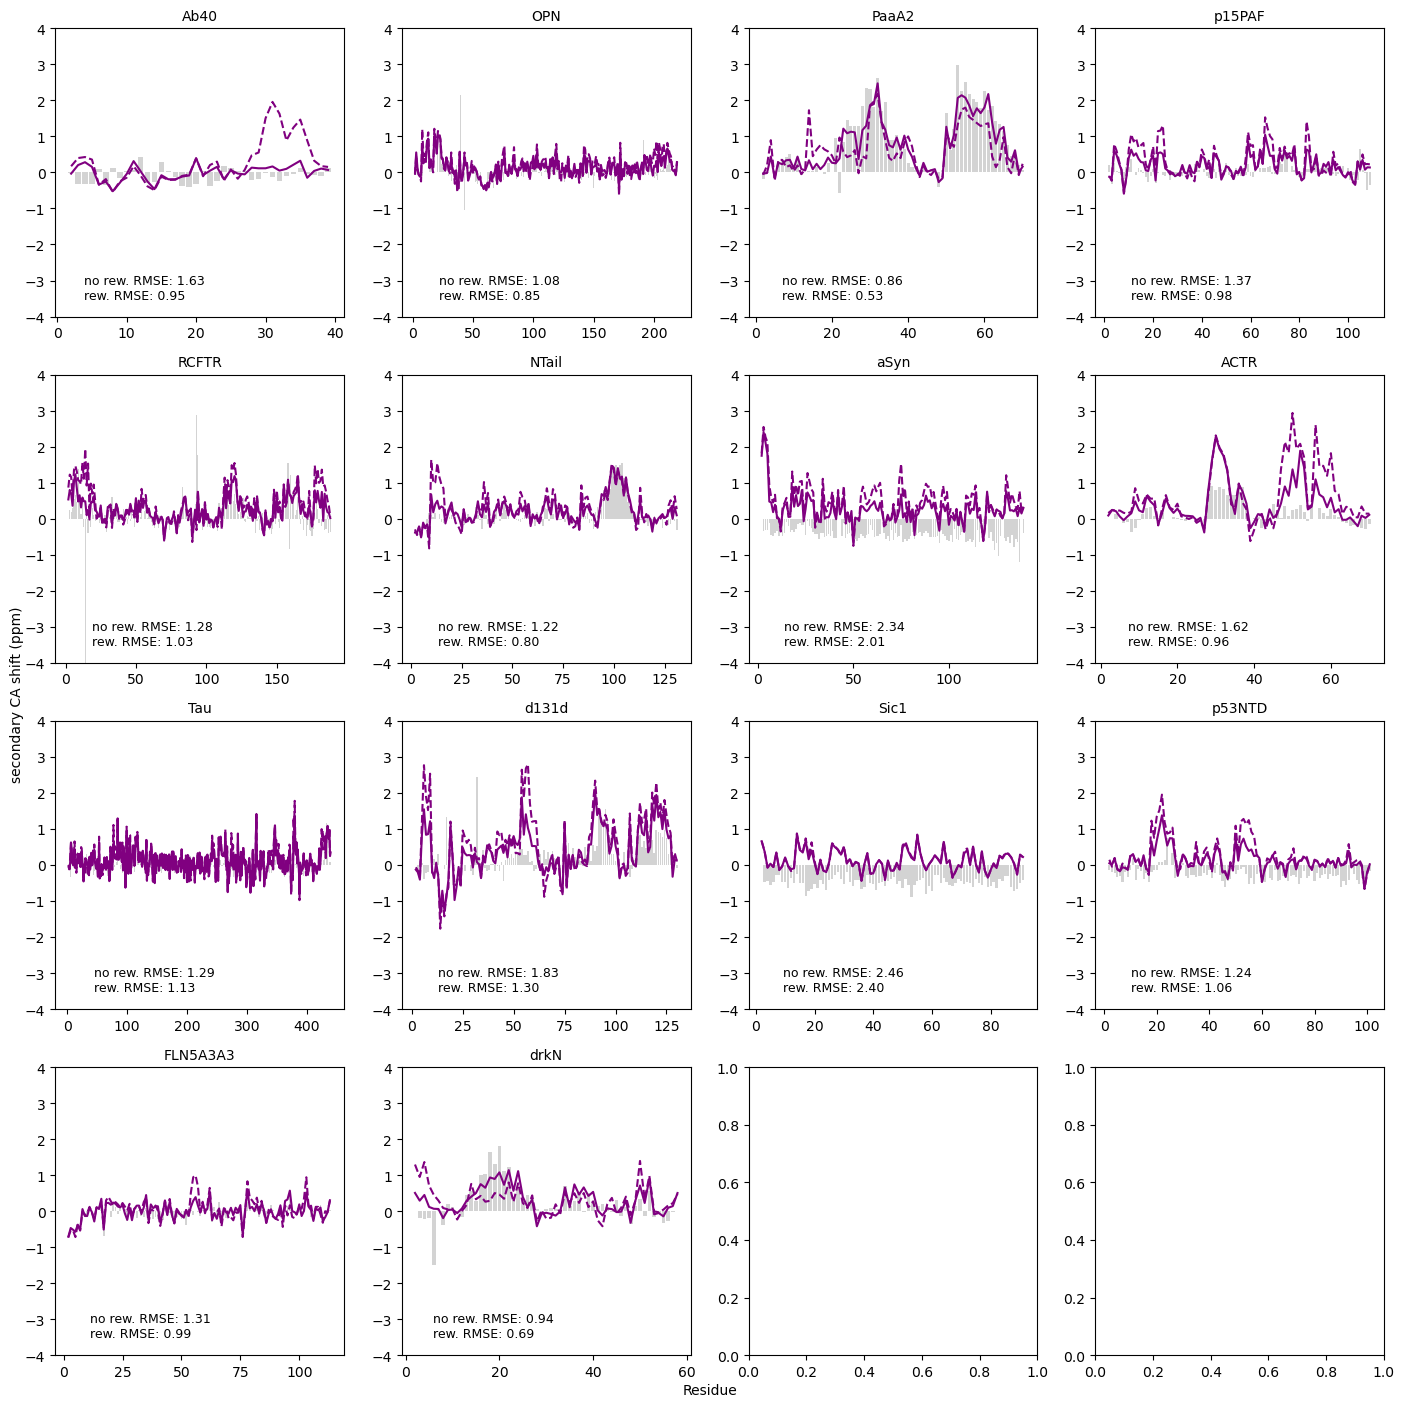

In [15]:
# final comparison of generated ensembles and experimental data: prior and optimal posterior (cross-validated with RDCs)

# plot CA secondary shifts (using potenci for random coil) - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'idp-o'

nucleus = 'CA'
ESS_threshold=100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

PROTEINS = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*1,len(PROTEINS)*1))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # load experimental shifts
    expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat', bmrb_stats_file, sigma_cutoff=3.0)

    # load RC shifts
    potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx
    # extract weights
    weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
    weights_nan = csrew['weights']

    # load calculated chemical shifts
    calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

    # calculate experimental secondary shifts
    potenci_residues = []
    potenci_shifts = []
    for key in list(potenci.keys()):
        if key[1]==nucleus:
            potenci_residues.append(key[0])
            potenci_shifts.append(potenci[key])

    exp_residues = []
    exp_shifts = []
    for key in list(expshifts.keys()):
        if key[1]==nucleus:
            exp_residues.append(key[0])
            exp_shifts.append(expshifts[key])

    potenci_residues = np.array(potenci_residues)
    potenci_shifts = np.array(potenci_shifts)
    exp_residues = np.array(exp_residues)
    exp_shifts = np.array(exp_shifts)

    common_residues = np.intersect1d(potenci_residues, exp_residues)
    indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
    indices_e = np.where(np.isin(exp_residues, common_residues))[0]
    SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

    # calculated secondary shifts from models (before/after reweighting)
    calc_vals = []
    calc_residues = []
    for res in potenci_residues:
        try:
            calc_vals.append(list(calcshifts.loc[res, nucleus]))
            calc_residues.append(res)
        except KeyError:
            continue

    calc_residues = np.array(calc_residues)
    calc_vals = np.array(calc_vals).T

    # Average across models
    prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)  # remove unphysical structures
    posterior = np.average(calc_vals, weights=weights, axis=0)

    # Align Potenci shifts with calc_residues
    indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
    potenci_for_calc = potenci_shifts[indices_p2]

    # Now compute secondary shifts
    SSprior = prior - potenci_for_calc
    SSposterior = posterior - potenci_for_calc


    ax.bar(exp_residues[indices_e], SSexp, color = 'lightgrey')
    ax.plot(calc_residues, SSprior, color = 'purple', label='no rew.', linestyle='dashed')
    ax.plot(calc_residues, SSposterior, color = 'purple', label='rew.')
    ax.set_ylim(-4,4)

    text_string = str("no rew. RMSE: {:.2f}\n".format(csrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(csrew['all_post_rmse'][opt_post_idx]))
    ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SSshifts_{nucleus}_{model}_exp_vs_calc.png', dpi=200)



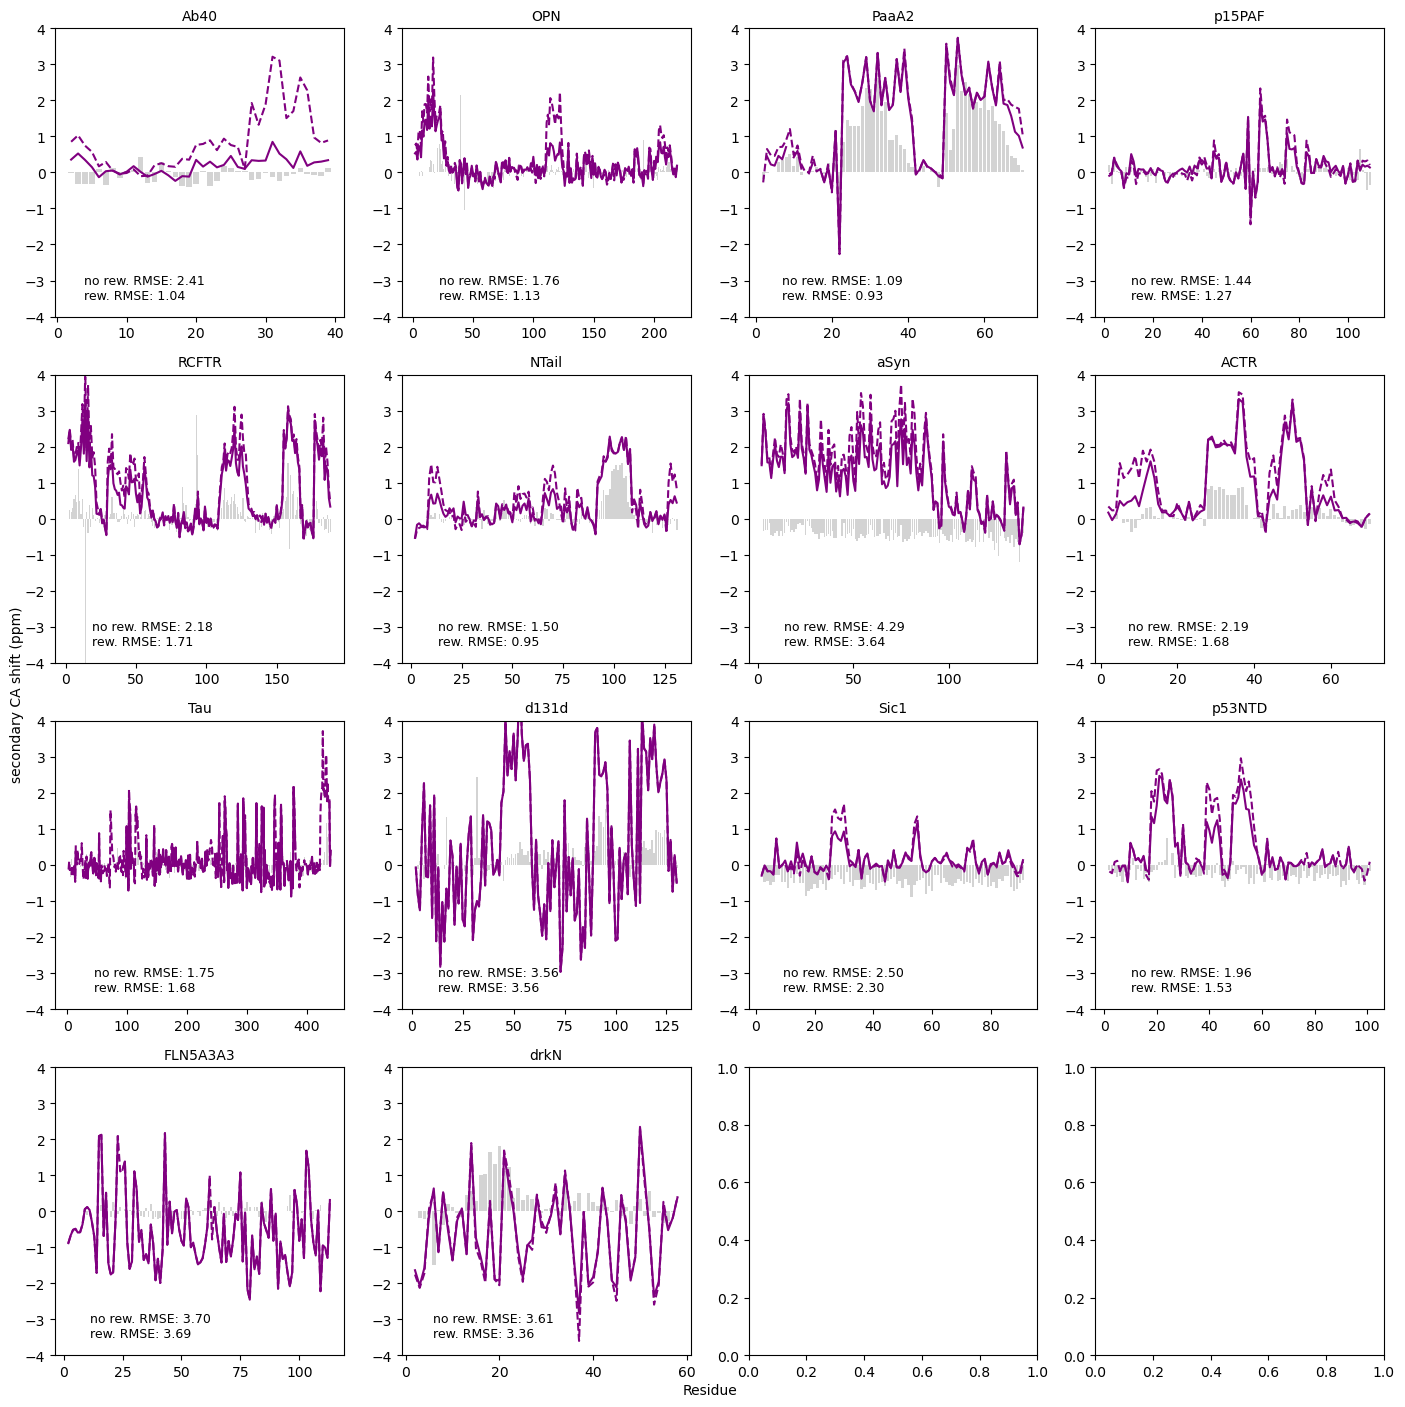

In [16]:
# final comparison of generated ensembles and experimental data: prior and optimal posterior (cross-validated with RDCs)

# plot CA secondary shifts (using potenci for random coil) - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'peptron_stable_pdb_idrome_20250812_256000'

nucleus = 'CA'
ESS_threshold=100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

PROTEINS = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*1,len(PROTEINS)*1))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # load experimental shifts
    expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat', bmrb_stats_file, sigma_cutoff=3.0)

    # load RC shifts
    potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx
    # extract weights
    weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
    weights_nan = csrew['weights']

    # load calculated chemical shifts
    calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

    # calculate experimental secondary shifts
    potenci_residues = []
    potenci_shifts = []
    for key in list(potenci.keys()):
        if key[1]==nucleus:
            potenci_residues.append(key[0])
            potenci_shifts.append(potenci[key])

    exp_residues = []
    exp_shifts = []
    for key in list(expshifts.keys()):
        if key[1]==nucleus:
            exp_residues.append(key[0])
            exp_shifts.append(expshifts[key])

    potenci_residues = np.array(potenci_residues)
    potenci_shifts = np.array(potenci_shifts)
    exp_residues = np.array(exp_residues)
    exp_shifts = np.array(exp_shifts)

    common_residues = np.intersect1d(potenci_residues, exp_residues)
    indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
    indices_e = np.where(np.isin(exp_residues, common_residues))[0]
    SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

    # calculated secondary shifts from models (before/after reweighting)
    calc_vals = []
    calc_residues = []
    for res in potenci_residues:
        try:
            calc_vals.append(list(calcshifts.loc[res, nucleus]))
            calc_residues.append(res)
        except KeyError:
            continue

    calc_residues = np.array(calc_residues)
    calc_vals = np.array(calc_vals).T

    # Average across models
    prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)  # remove unphysical structures
    posterior = np.average(calc_vals, weights=weights, axis=0)

    # Align Potenci shifts with calc_residues
    indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
    potenci_for_calc = potenci_shifts[indices_p2]

    # Now compute secondary shifts
    SSprior = prior - potenci_for_calc
    SSposterior = posterior - potenci_for_calc


    ax.bar(exp_residues[indices_e], SSexp, color = 'lightgrey')
    ax.plot(calc_residues, SSprior, color = 'purple', label='no rew.', linestyle='dashed')
    ax.plot(calc_residues, SSposterior, color = 'purple', label='rew.')
    ax.set_ylim(-4,4)

    text_string = str("no rew. RMSE: {:.2f}\n".format(csrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(csrew['all_post_rmse'][opt_post_idx]))
    ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SSshifts_{nucleus}_{model}_exp_vs_calc.png', dpi=200)



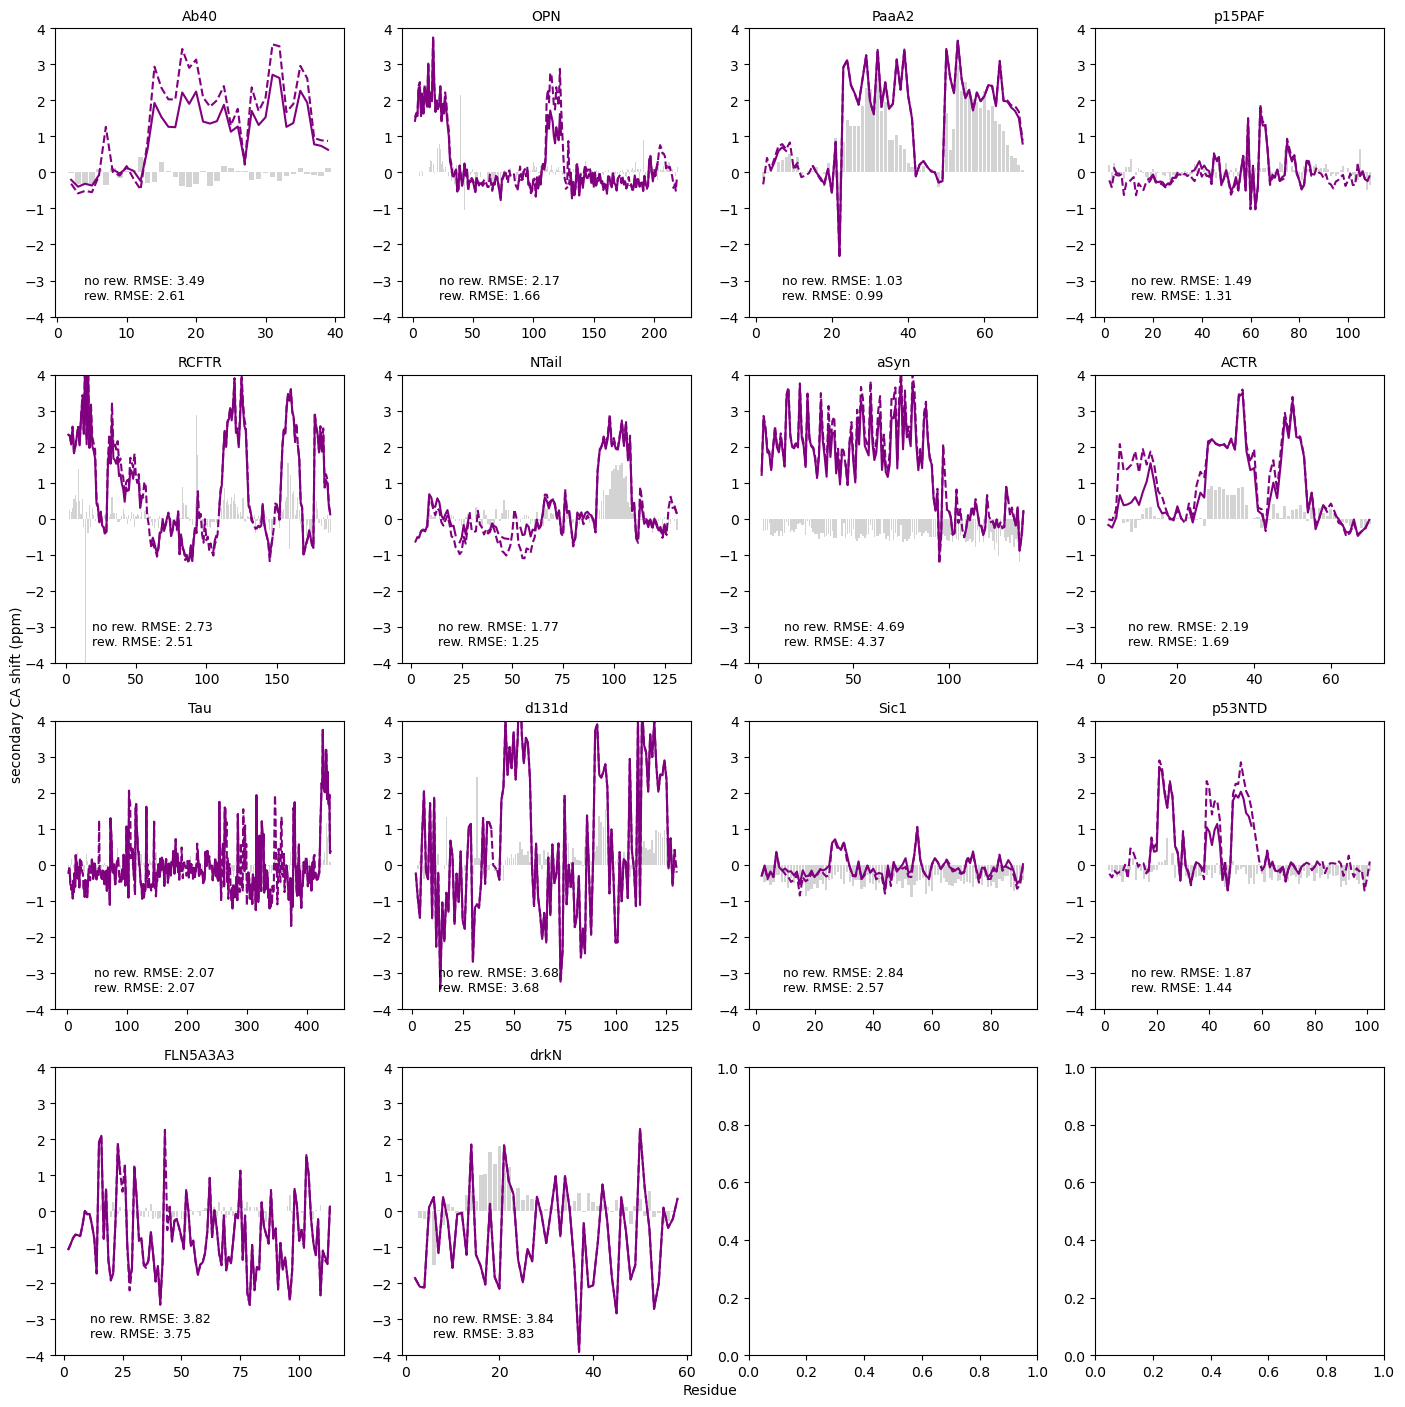

In [2]:
# final comparison of generated ensembles and experimental data: prior and optimal posterior (cross-validated with RDCs)

# plot CA secondary shifts (using potenci for random coil) - exp vs calc (for every model separately as a plot and each protein per plot)
model = 'peptron_stable_pdb_20250809_236800'

nucleus = 'CA'
ESS_threshold=100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'
# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy',allow_pickle=True).item()

PROTEINS = list(corrdict[model].keys())

# Create subplots
ncols = math.ceil(math.sqrt(len(PROTEINS)))
nrows = math.ceil(len(PROTEINS) / ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=False, sharey=False, figsize=(len(PROTEINS)*1,len(PROTEINS)*1))
axs = axes.ravel() 
for i, prot in enumerate(PROTEINS):
    ax = axs[i]
    ax.set_title(prot, fontsize = 10)

    if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
        continue
    csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy',allow_pickle=True).item()
    if 'note' in list(csrew.keys()): # skip entries where reweighting with CS data failed
        continue

    # load experimental shifts
    expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat', bmrb_stats_file, sigma_cutoff=3.0)

    # load RC shifts
    potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

    # find optimal posterior
    # (best agreement with RDCs satisfying >=100 - else prior is taken i.e. no reweighting)
    min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]>=ESS_threshold: # best posterior is above ESS threshold
        min_idx = min_idx
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold and np.nanmax(corrdict[model][prot]['ESS'])>ESS_threshold: # posterior below ESS_threshold but enough frames for reweighting
        mask = corrdict[model][prot]['ESS'] >= ESS_threshold
        valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
        min_idx = np.where(corrdict[model][prot]['Post. Q']==np.nanmin(valid))[0][0]
    if corrdict[model][prot]['ESS'][min_idx]<ESS_threshold:
        min_idx=np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0] # first index not nan
    opt_post_idx = min_idx
    # extract weights
    weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
    weights_nan = csrew['weights']

    # load calculated chemical shifts
    calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

    # calculate experimental secondary shifts
    potenci_residues = []
    potenci_shifts = []
    for key in list(potenci.keys()):
        if key[1]==nucleus:
            potenci_residues.append(key[0])
            potenci_shifts.append(potenci[key])

    exp_residues = []
    exp_shifts = []
    for key in list(expshifts.keys()):
        if key[1]==nucleus:
            exp_residues.append(key[0])
            exp_shifts.append(expshifts[key])

    potenci_residues = np.array(potenci_residues)
    potenci_shifts = np.array(potenci_shifts)
    exp_residues = np.array(exp_residues)
    exp_shifts = np.array(exp_shifts)

    common_residues = np.intersect1d(potenci_residues, exp_residues)
    indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
    indices_e = np.where(np.isin(exp_residues, common_residues))[0]
    SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

    # calculated secondary shifts from models (before/after reweighting)
    calc_vals = []
    calc_residues = []
    for res in potenci_residues:
        try:
            calc_vals.append(list(calcshifts.loc[res, nucleus]))
            calc_residues.append(res)
        except KeyError:
            continue

    calc_residues = np.array(calc_residues)
    calc_vals = np.array(calc_vals).T

    # Average across models
    prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)  # remove unphysical structures
    posterior = np.average(calc_vals, weights=weights, axis=0)

    # Align Potenci shifts with calc_residues
    indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
    potenci_for_calc = potenci_shifts[indices_p2]

    # Now compute secondary shifts
    SSprior = prior - potenci_for_calc
    SSposterior = posterior - potenci_for_calc


    ax.bar(exp_residues[indices_e], SSexp, color = 'lightgrey')
    ax.plot(calc_residues, SSprior, color = 'purple', label='no rew.', linestyle='dashed')
    ax.plot(calc_residues, SSposterior, color = 'purple', label='rew.')
    ax.set_ylim(-4,4)

    text_string = str("no rew. RMSE: {:.2f}\n".format(csrew['prior_rmse'])) + str("rew. RMSE: {:.2f}".format(csrew['all_post_rmse'][opt_post_idx]))
    ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=9)

# Set one master x and y label
fig.text(0.5, -0.00, 'Residue', ha='center', fontsize=10)  # master x-label
fig.text(-0.00, 0.5, f'secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)  # master y-label

plt.tight_layout()
plt.savefig(output_path+f'FINAL_SSshifts_{nucleus}_{model}_exp_vs_calc.png', dpi=200)



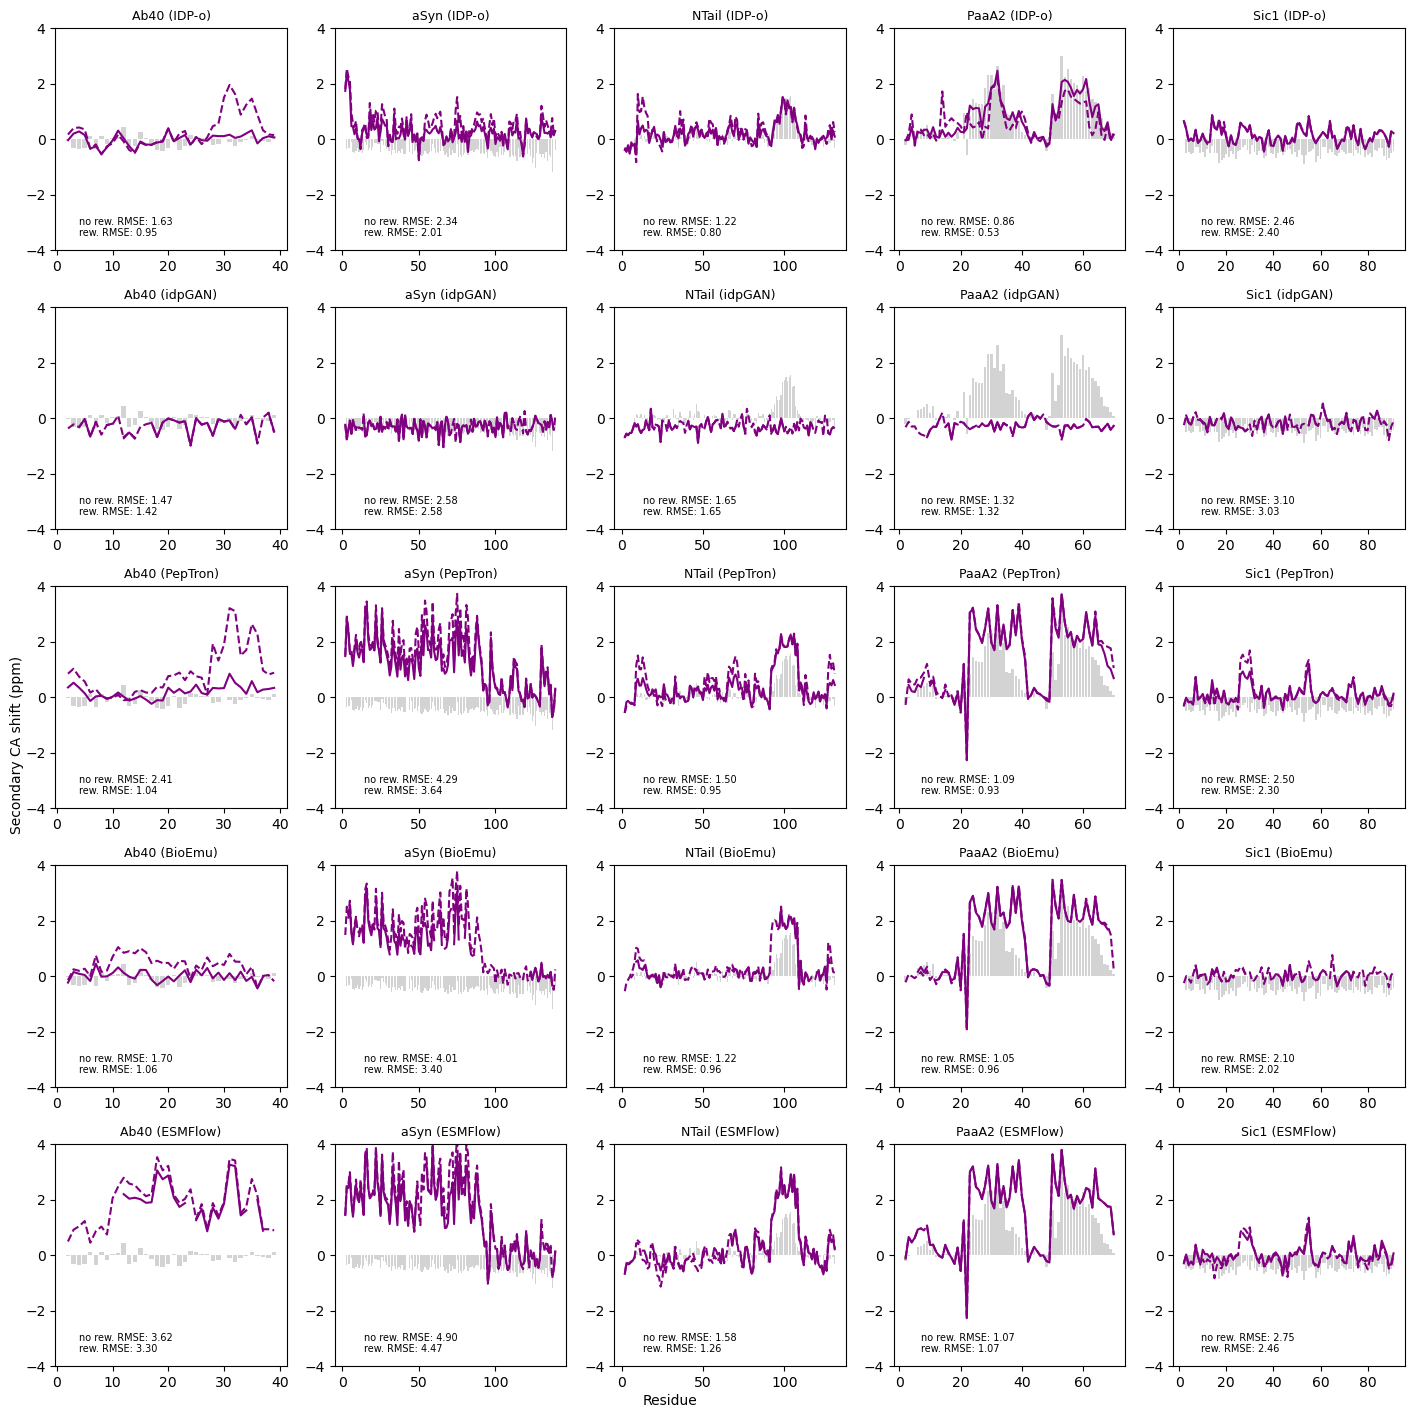

In [4]:
# EXAMPLE PLOT FOR PAPER

# parameters
models = ['idp-o', 'idpgan', 'peptron_stable_pdb_idrome_20250812_256000', 'bioemu', 'esmflow']   # list of models
names = ['IDP-o', 'idpGAN', 'PepTron', 'BioEmu', 'ESMFlow']   # list of models
proteins = ['Ab40', 'aSyn', 'NTail', 'PaaA2', 'Sic1']       # list of proteins
nucleus = 'CA'
ESS_threshold = 100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'

# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy', allow_pickle=True).item()

# prepare figure
nrows = len(models)
ncols = len(proteins)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3), sharex=False, sharey=False)

# force 2D axes array
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes[np.newaxis, :]
elif ncols == 1:
    axes = axes[:, np.newaxis]

for r, model in enumerate(models):
    for c, prot in enumerate(proteins):
        ax = axes[r, c]
        ax.set_title(f"{prot} ({names[r]})", fontsize=9)

        # skip if CSrew file not present
        if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
            continue
        csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy', allow_pickle=True).item()
        if 'note' in list(csrew.keys()):
            continue  # skip failed entries

        # load experimental shifts
        expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat',
                                                        bmrb_stats_file,
                                                        sigma_cutoff=3.0)

        # load RC shifts
        potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

        # ---- find optimal posterior ----
        min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
        if corrdict[model][prot]['ESS'][min_idx] >= ESS_threshold:
            min_idx = min_idx
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold and np.nanmax(corrdict[model][prot]['ESS']) > ESS_threshold:
            mask = corrdict[model][prot]['ESS'] >= ESS_threshold
            valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
            min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(valid))[0][0]
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold:
            min_idx = np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0]
        opt_post_idx = min_idx

        # extract weights
        weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
        weights_nan = csrew['weights']

        # load calculated chemical shifts
        calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

        # experimental secondary shifts (exp - RC)
        potenci_residues, potenci_shifts = [], []
        for key in potenci.keys():
            if key[1] == nucleus:
                potenci_residues.append(key[0])
                potenci_shifts.append(potenci[key])

        exp_residues, exp_shifts = [], []
        for key in expshifts.keys():
            if key[1] == nucleus:
                exp_residues.append(key[0])
                exp_shifts.append(expshifts[key])

        potenci_residues = np.array(potenci_residues)
        potenci_shifts = np.array(potenci_shifts)
        exp_residues = np.array(exp_residues)
        exp_shifts = np.array(exp_shifts)

        common_residues = np.intersect1d(potenci_residues, exp_residues)
        indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
        indices_e = np.where(np.isin(exp_residues, common_residues))[0]
        SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

        # calculated shifts (prior/posterior)
        calc_vals, calc_residues = [], []
        for res in potenci_residues:
            try:
                calc_vals.append(list(calcshifts.loc[res, nucleus]))
                calc_residues.append(res)
            except KeyError:
                continue
        calc_residues = np.array(calc_residues)
        calc_vals = np.array(calc_vals).T

        # average across ensemble
        prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)
        posterior = np.average(calc_vals, weights=weights, axis=0)

        # align Potenci with calc_residues
        indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
        potenci_for_calc = potenci_shifts[indices_p2]

        # secondary shifts
        SSprior = prior - potenci_for_calc
        SSposterior = posterior - potenci_for_calc

        # ---- plotting ----
        ax.bar(exp_residues[indices_e], SSexp, color='lightgrey')
        ax.plot(calc_residues, SSprior, color='purple', linestyle='dashed', label='no rew.')
        ax.plot(calc_residues, SSposterior, color='purple', label='rew.')
        ax.set_ylim(-4, 4)

        text_string = f"no rew. RMSE: {csrew['prior_rmse']:.2f}\nrew. RMSE: {csrew['all_post_rmse'][opt_post_idx]:.2f}"
        ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=7)

# master labels
fig.text(0.5, 0.06, 'Residue', ha='center', fontsize=10)
fig.text(0.06, 0.5, f'Secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)

plt.tight_layout(rect=[0.06, 0.06, 1, 1])
plt.savefig(output_path+f'EXAMPLE_CS_models_vs_proteins.png', dpi=200)



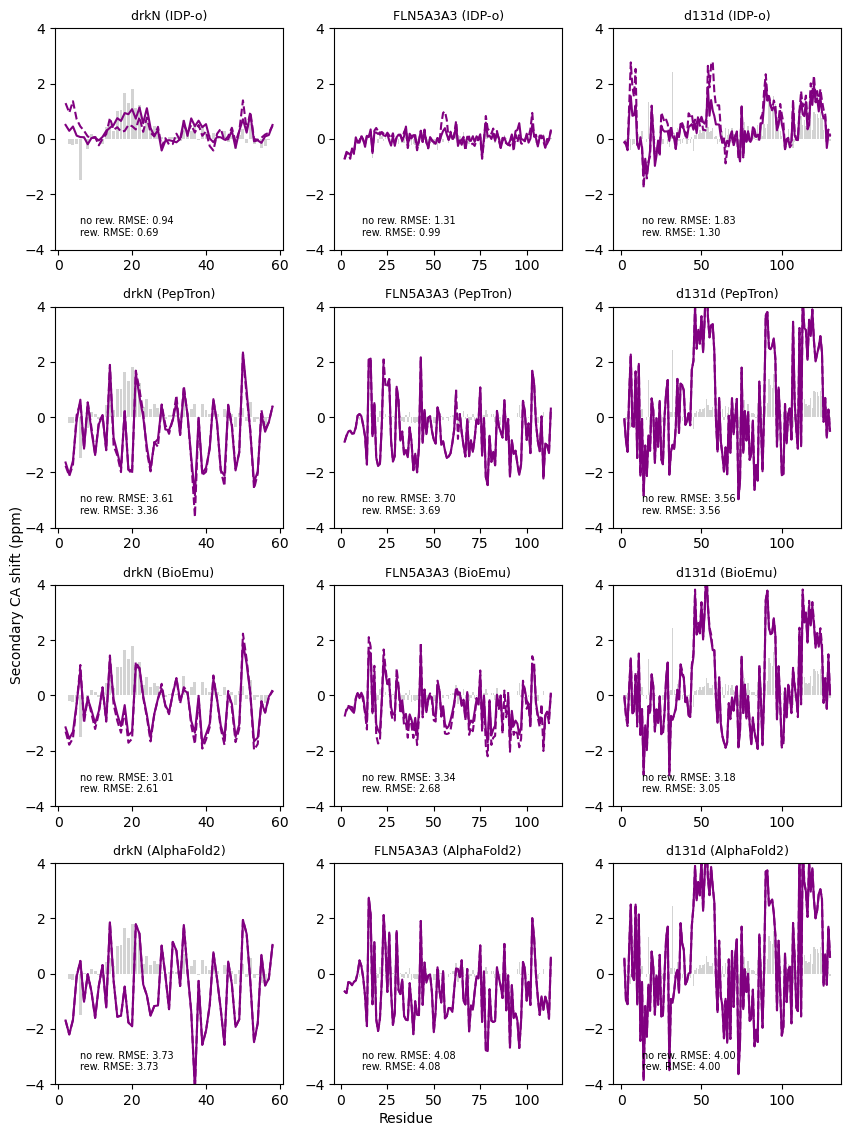

In [5]:
# EXAMPLE PLOT FOR PAPER

# parameters
models = ['idp-o', 'peptron_stable_pdb_idrome_20250812_256000', 'bioemu', 'alphafold']   # list of models
names = ['IDP-o', 'PepTron', 'BioEmu', 'AlphaFold2']   # list of models
proteins = ['drkN', 'FLN5A3A3', 'd131d']       # list of proteins
nucleus = 'CA'
ESS_threshold = 100
CS_predictor = 'UCBshift'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'

# RDC cross validation data
corrdict = np.load('RDC_analyses/RDC_CSrew_corr_analysis_dict.npy', allow_pickle=True).item()

# prepare figure
nrows = len(models)
ncols = len(proteins)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3), sharex=False, sharey=False)

# force 2D axes array
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = axes[np.newaxis, :]
elif ncols == 1:
    axes = axes[:, np.newaxis]

for r, model in enumerate(models):
    for c, prot in enumerate(proteins):
        ax = axes[r, c]
        ax.set_title(f"{prot} ({names[r]})", fontsize=9)

        # skip if CSrew file not present
        if not os.path.exists(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy'):
            continue
        csrew = np.load(f'../protonated_predictions/{model}/{prot}/CSrew_{CS_predictor}.npy', allow_pickle=True).item()
        if 'note' in list(csrew.keys()):
            continue  # skip failed entries

        # load experimental shifts
        expshifts = load_and_filter_experimental_shifts(f'../EXP_DATA/{prot}/CS.dat',
                                                        bmrb_stats_file,
                                                        sigma_cutoff=3.0)

        # load RC shifts
        potenci = load_potenci_shifts(f'potenci_data/{prot}_RCshifts.dat')

        # ---- find optimal posterior ----
        min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(corrdict[model][prot]['Post. Q']))[0][0]
        if corrdict[model][prot]['ESS'][min_idx] >= ESS_threshold:
            min_idx = min_idx
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold and np.nanmax(corrdict[model][prot]['ESS']) > ESS_threshold:
            mask = corrdict[model][prot]['ESS'] >= ESS_threshold
            valid = np.array(corrdict[model][prot]['Post. Q'])[mask]
            min_idx = np.where(corrdict[model][prot]['Post. Q'] == np.nanmin(valid))[0][0]
        elif corrdict[model][prot]['ESS'][min_idx] < ESS_threshold:
            min_idx = np.where(~np.isnan(corrdict[model][prot]['ESS']))[0][0]
        opt_post_idx = min_idx

        # extract weights
        weights = np.nan_to_num(csrew['all_weights'][opt_post_idx], nan=0)
        weights_nan = csrew['weights']

        # load calculated chemical shifts
        calcshifts = load_generated_shifts(f'../processed_predictions/{model}/{CS_predictor}-{prot}.csv')

        # experimental secondary shifts (exp - RC)
        potenci_residues, potenci_shifts = [], []
        for key in potenci.keys():
            if key[1] == nucleus:
                potenci_residues.append(key[0])
                potenci_shifts.append(potenci[key])

        exp_residues, exp_shifts = [], []
        for key in expshifts.keys():
            if key[1] == nucleus:
                exp_residues.append(key[0])
                exp_shifts.append(expshifts[key])

        potenci_residues = np.array(potenci_residues)
        potenci_shifts = np.array(potenci_shifts)
        exp_residues = np.array(exp_residues)
        exp_shifts = np.array(exp_shifts)

        common_residues = np.intersect1d(potenci_residues, exp_residues)
        indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
        indices_e = np.where(np.isin(exp_residues, common_residues))[0]
        SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

        # calculated shifts (prior/posterior)
        calc_vals, calc_residues = [], []
        for res in potenci_residues:
            try:
                calc_vals.append(list(calcshifts.loc[res, nucleus]))
                calc_residues.append(res)
            except KeyError:
                continue
        calc_residues = np.array(calc_residues)
        calc_vals = np.array(calc_vals).T

        # average across ensemble
        prior = np.average(calc_vals[~np.isnan(weights_nan), :], axis=0)
        posterior = np.average(calc_vals, weights=weights, axis=0)

        # align Potenci with calc_residues
        indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
        potenci_for_calc = potenci_shifts[indices_p2]

        # secondary shifts
        SSprior = prior - potenci_for_calc
        SSposterior = posterior - potenci_for_calc

        # ---- plotting ----
        ax.bar(exp_residues[indices_e], SSexp, color='lightgrey')
        ax.plot(calc_residues, SSprior, color='purple', linestyle='dashed', label='no rew.')
        ax.plot(calc_residues, SSposterior, color='purple', label='rew.')
        ax.set_ylim(-4, 4)

        text_string = f"no rew. RMSE: {csrew['prior_rmse']:.2f}\nrew. RMSE: {csrew['all_post_rmse'][opt_post_idx]:.2f}"
        ax.text(0.1*np.max(potenci_residues), -3.5, text_string, fontsize=7)

# master labels
fig.text(0.5, 0.06, 'Residue', ha='center', fontsize=10)
fig.text(0.06, 0.5, f'Secondary {nucleus} shift (ppm)', va='center', rotation='vertical', fontsize=10)

plt.tight_layout(rect=[0.06, 0.06, 1, 1])
plt.savefig(output_path+f'EXAMPLE_foldableseqs_CS_models_vs_proteins.png', dpi=200)



In [18]:
###############################
### Checking for outlier CS ###
###############################

# === CONFIG ===
fasta_dir = '../predictions/fasta/'
exp_root = '../EXP_DATA/'
bmrb_stats_file = '../EXP_DATA/cs_stat_aa_filt.csv'

# === Load protein list ===
files = find_fasta_filenames(fasta_dir)
proteins = [f[:-6] for f in files]
#print(f"Proteins: {proteins}")

# check for which of these proteins there are chemical shift data
CSproteins = []
for protein in proteins:
    if os.path.exists(exp_root+f"{protein}/CS.dat"):
        CSproteins.append(protein)

for prot in CSproteins:

    expfile = f'../EXP_DATA/{prot}/CS.dat'

    exp_dict = load_experimental_shifts(expfile)
    exp_dict_filt = load_and_filter_experimental_shifts(expfile, bmrb_stats_file, sigma_cutoff=3.0)
    n_unfiltered = len(exp_dict.keys())
    n_filtered = len(exp_dict_filt.keys())
    diff = n_unfiltered-n_filtered
    print(f'{prot}: {diff} chemical shifts removed')
 

FUS: 0 chemical shifts removed
Ab40: 0 chemical shifts removed
OPN: 0 chemical shifts removed
A2: 0 chemical shifts removed
PaaA2: 0 chemical shifts removed
DSS1: 0 chemical shifts removed
p15PAF: 0 chemical shifts removed
ProTa: 0 chemical shifts removed
RCFTR: 0 chemical shifts removed
BecN: 0 chemical shifts removed
NTail: 0 chemical shifts removed
aSyn: 0 chemical shifts removed
Ash1: 0 chemical shifts removed
ERNTD: 0 chemical shifts removed
ACTR: 0 chemical shifts removed
Tau: 0 chemical shifts removed
d131d: 2 chemical shifts removed
ChiZ: 0 chemical shifts removed
ANAC013: 0 chemical shifts removed
MAP2c: 0 chemical shifts removed
Sic1: 0 chemical shifts removed
ANAC046: 0 chemical shifts removed
p53NTD: 0 chemical shifts removed
FLN5A3A3: 0 chemical shifts removed
drkN: 0 chemical shifts removed
